In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for available devices (CUDA, MPS for Mac, or CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using device: {device} (CUDA)")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"Using device: {device} (Metal Performance Shaders - Mac)")
else:
    device = torch.device('cpu')
    print(f"Using device: {device}")

print(f"PyTorch version: {torch.__version__}")

# Set matplotlib style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


Using device: mps (Metal Performance Shaders - Mac)
PyTorch version: 2.7.1


In [2]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")


Training samples: 60000
Test samples: 10000
Batch size: 64
Number of training batches: 938
Number of test batches: 157


Sample images from MNIST dataset:


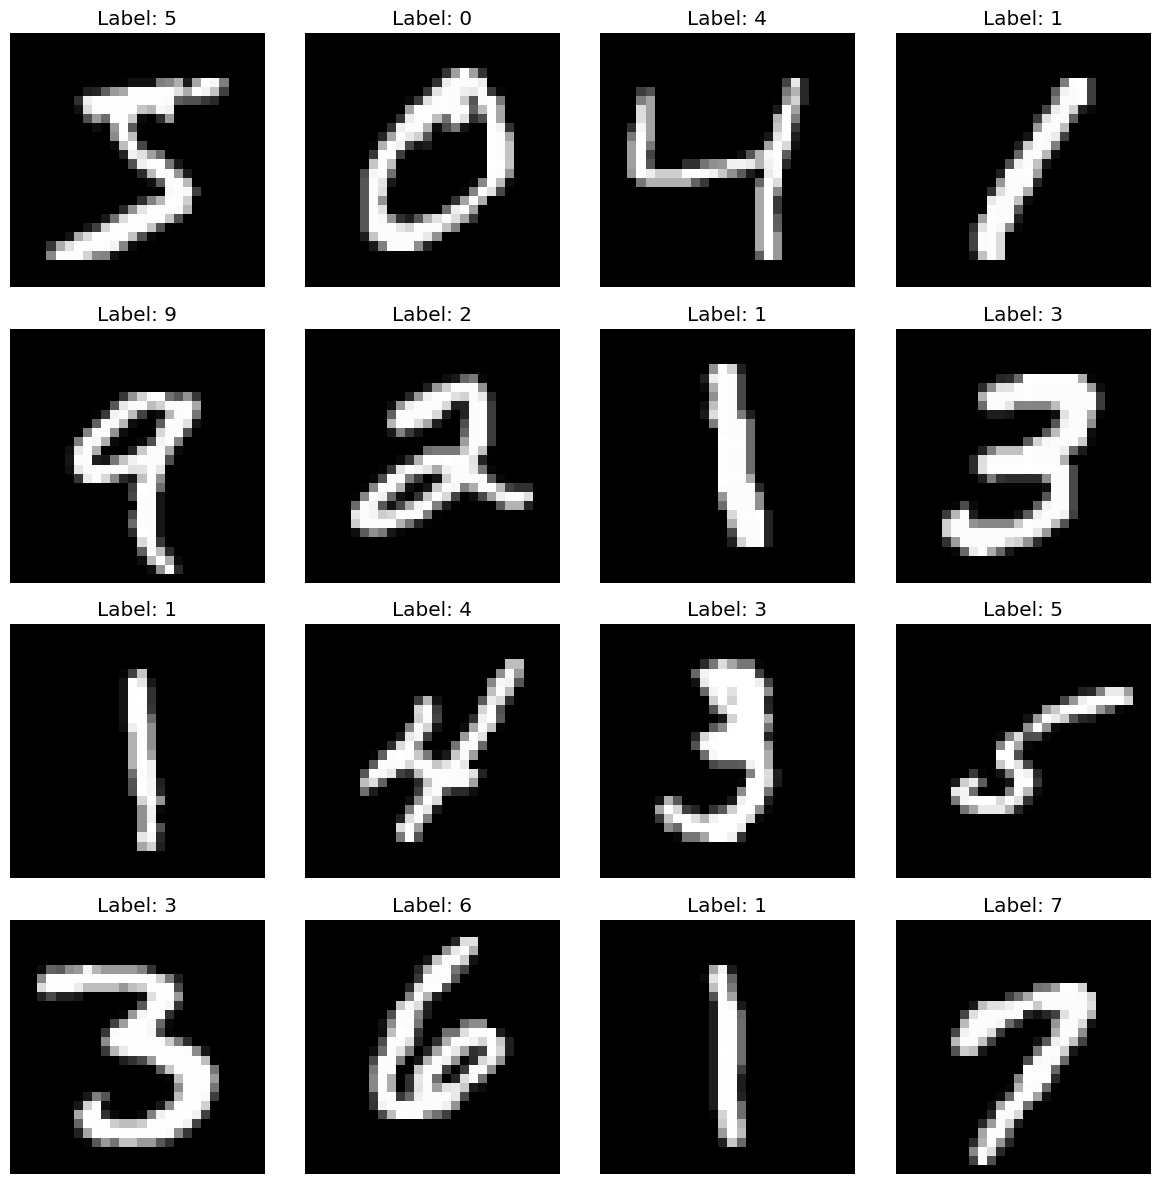

In [3]:
# Visualize some samples from the dataset
def visualize_samples(dataset, num_samples=16):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()
    
    for i in range(num_samples):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Sample images from MNIST dataset:")
visualize_samples(train_dataset)


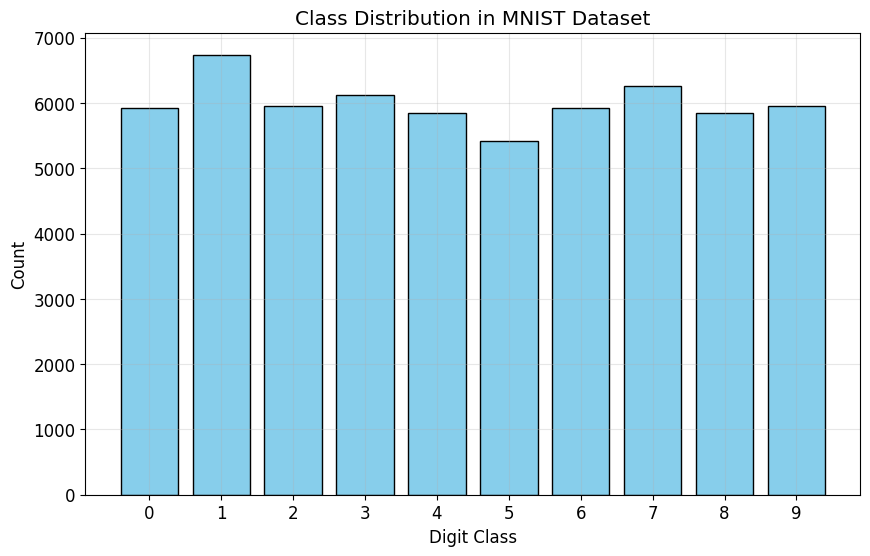

Class distribution:
Digit 0: 5923 samples
Digit 1: 6742 samples
Digit 2: 5958 samples
Digit 3: 6131 samples
Digit 4: 5842 samples
Digit 5: 5421 samples
Digit 6: 5918 samples
Digit 7: 6265 samples
Digit 8: 5851 samples
Digit 9: 5949 samples


In [4]:
# Analyze class distribution
def analyze_class_distribution(dataset):
    labels = [dataset[i][1] for i in range(len(dataset))]
    unique, counts = np.unique(labels, return_counts=True)
    
    plt.figure(figsize=(10, 6))
    plt.bar(unique, counts, color='skyblue', edgecolor='black')
    plt.xlabel('Digit Class')
    plt.ylabel('Count')
    plt.title('Class Distribution in MNIST Dataset')
    plt.xticks(unique)
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("Class distribution:")
    for digit, count in zip(unique, counts):
        print(f"Digit {digit}: {count} samples")

analyze_class_distribution(train_dataset)


In [5]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, num_classes=10):
        super(SimpleNeuralNetwork, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
        # Store intermediate activations for visualization
        self.activations = {}
        
    def forward(self, x):
        # Flatten the input image
        x = x.view(-1, 784)
        self.activations['input'] = x.detach()
        
        # First hidden layer
        x = self.fc1(x)
        self.activations['fc1_pre_relu'] = x.detach()
        x = F.relu(x)
        self.activations['fc1_post_relu'] = x.detach()
        x = self.dropout(x)
        self.activations['fc1_post_dropout'] = x.detach()
        
        # Second hidden layer
        x = self.fc2(x)
        self.activations['fc2_pre_relu'] = x.detach()
        x = F.relu(x)
        self.activations['fc2_post_relu'] = x.detach()
        x = self.dropout(x)
        self.activations['fc2_post_dropout'] = x.detach()
        
        # Output layer
        x = self.fc3(x)
        self.activations['output'] = x.detach()
        
        return x
    
    def get_feature_maps(self):
        """Return the stored activations (feature maps) from the last forward pass"""
        return self.activations

# Create model instance
model = SimpleNeuralNetwork().to(device)
print("Model architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Model architecture:
SimpleNeuralNetwork(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 118,282
Trainable parameters: 118,282


In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")


Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Learning rate: 0.001


In [7]:
def visualize_feature_maps(model, sample_input, sample_label):
    """Visualize the feature maps (activations) at each layer"""
    model.eval()
    with torch.no_grad():
        # Forward pass to get activations
        _ = model(sample_input.to(device))
        activations = model.get_feature_maps()
    
    # Create subplots for visualization
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f'Feature Maps for Sample (Label: {sample_label})', fontsize=16)
    
    # Plot original input
    axes[0, 0].imshow(sample_input.squeeze().cpu(), cmap='gray')
    axes[0, 0].set_title('Original Input (28x28)')
    axes[0, 0].axis('off')
    
    # Plot histograms of activations at each layer
    layer_names = ['fc1_pre_relu', 'fc1_post_relu', 'fc2_pre_relu', 'fc2_post_relu', 'output']
    titles = ['FC1 (Pre-ReLU)', 'FC1 (Post-ReLU)', 'FC2 (Pre-ReLU)', 'FC2 (Post-ReLU)', 'Output Layer']
    
    for idx, (layer_name, title) in enumerate(zip(layer_names, titles)):
        if idx < 3:
            row, col = 0, idx + 1
        else:
            row, col = 1, idx - 3
            
        activation = activations[layer_name].cpu().numpy().flatten()
        axes[row, col].hist(activation, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[row, col].set_title(f'{title}\n(Mean: {activation.mean():.3f}, Std: {activation.std():.3f})')
        axes[row, col].set_xlabel('Activation Value')
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].grid(True, alpha=0.3)
    
    # Plot activation statistics
    axes[1, 2].axis('off')
    stats_text = "Activation Statistics:\n\n"
    for layer_name, title in zip(layer_names, titles):
        activation = activations[layer_name].cpu().numpy()
        stats_text += f"{title}:\n"
        stats_text += f"  Shape: {activation.shape}\n"
        stats_text += f"  Min: {activation.min():.3f}\n"
        stats_text += f"  Max: {activation.max():.3f}\n"
        stats_text += f"  Mean: {activation.mean():.3f}\n"
        stats_text += f"  Std: {activation.std():.3f}\n\n"
    
    axes[1, 2].text(0.1, 0.9, stats_text, transform=axes[1, 2].transAxes, 
                   fontsize=10, verticalalignment='top', fontfamily='monospace')
    
    # Visualize first layer weights as images
    weights = model.fc1.weight.data.cpu().numpy()  # Shape: (128, 784)
    # Reshape to visualize as 28x28 images
    weight_images = weights.reshape(128, 28, 28)
    
    # Show first 16 learned filters
    axes[1, 3].axis('off')
    mini_fig = plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(weight_images[i], cmap='RdBu', vmin=-weight_images.std(), vmax=weight_images.std())
        plt.title(f'Filter {i+1}', fontsize=8)
        plt.axis('off')
    plt.suptitle('First 16 Learned Filters (FC1 Weights)', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    plt.tight_layout()
    plt.show()

def visualize_activation_flow(model, sample_input):
    """Visualize how activations flow through the network"""
    model.eval()
    with torch.no_grad():
        _ = model(sample_input.to(device))
        activations = model.get_feature_maps()
    
    # Create a flow diagram
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    layer_names = ['input', 'fc1_post_relu', 'fc2_post_relu', 'output']
    titles = ['Input\n(784)', 'Hidden Layer 1\n(128)', 'Hidden Layer 2\n(128)', 'Output\n(10)']
    
    for idx, (layer_name, title) in enumerate(zip(layer_names, titles)):
        if layer_name in activations:
            activation = activations[layer_name].cpu().numpy().flatten()
            
            # Create a visual representation of the activation
            if layer_name == 'input':
                # Reshape input to 28x28 for visualization
                img = activation.reshape(28, 28)
                axes[idx].imshow(img, cmap='gray')
            else:
                # For hidden layers, show activation values as bars
                axes[idx].bar(range(len(activation[:20])), activation[:20], 
                             color='skyblue', alpha=0.7)
                axes[idx].set_xlabel('Neuron Index')
                axes[idx].set_ylabel('Activation Value')
            
            axes[idx].set_title(title)
            if layer_name != 'input':
                axes[idx].grid(True, alpha=0.3)
    
    plt.suptitle('Activation Flow Through the Network', fontsize=16)
    plt.tight_layout()
    plt.show()


In [8]:
def visualize_loss_landscape(model, data_loader, criterion, device, resolution=20):
    """Visualize the loss landscape around the current model parameters"""
    model.eval()
    
    # Get a subset of data for loss computation
    data_subset = []
    target_subset = []
    for i, (data, target) in enumerate(data_loader):
        if i >= 5:  # Use only first 5 batches for speed
            break
        data_subset.append(data)
        target_subset.append(target)
    
    data_subset = torch.cat(data_subset, dim=0).to(device)
    target_subset = torch.cat(target_subset, dim=0).to(device)
    
    # Get current parameters
    params = []
    for param in model.parameters():
        params.append(param.data.clone().flatten())
    params = torch.cat(params)
    
    # Create random directions
    torch.manual_seed(42)
    direction1 = torch.randn_like(params)
    direction1 = direction1 / torch.norm(direction1)
    
    direction2 = torch.randn_like(params)
    direction2 = direction2 - torch.dot(direction2, direction1) * direction1
    direction2 = direction2 / torch.norm(direction2)
    
    # Define the range for perturbation
    alpha_range = np.linspace(-1, 1, resolution)
    beta_range = np.linspace(-1, 1, resolution)
    
    losses = np.zeros((resolution, resolution))
    
    print("Computing loss landscape...")
    for i, alpha in enumerate(alpha_range):
        for j, beta in enumerate(beta_range):
            # Perturb parameters
            perturbed_params = params + alpha * direction1 + beta * direction2
            
            # Set perturbed parameters
            param_idx = 0
            for param in model.parameters():
                param_size = param.numel()
                param.data = perturbed_params[param_idx:param_idx + param_size].reshape(param.shape)
                param_idx += param_size
            
            # Compute loss
            with torch.no_grad():
                output = model(data_subset)
                loss = criterion(output, target_subset)
                losses[i, j] = loss.item()
    
    # Restore original parameters
    param_idx = 0
    for param in model.parameters():
        param_size = param.numel()
        param.data = params[param_idx:param_idx + param_size].reshape(param.shape)
        param_idx += param_size
    
    # Plot loss landscape
    fig = plt.figure(figsize=(15, 5))
    
    # 2D contour plot
    ax1 = fig.add_subplot(1, 3, 1)
    contour = ax1.contour(alpha_range, beta_range, losses.T, levels=20)
    ax1.clabel(contour, inline=True, fontsize=8)
    ax1.set_xlabel('Direction 1')
    ax1.set_ylabel('Direction 2')
    ax1.set_title('Loss Landscape (Contour)')
    ax1.plot(0, 0, 'ro', markersize=8, label='Current Position')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2D heatmap
    ax2 = fig.add_subplot(1, 3, 2)
    heatmap = ax2.imshow(losses.T, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
    ax2.set_xlabel('Direction 1')
    ax2.set_ylabel('Direction 2')
    ax2.set_title('Loss Landscape (Heatmap)')
    ax2.plot(0, 0, 'ro', markersize=8, label='Current Position')
    ax2.legend()
    plt.colorbar(heatmap, ax=ax2, label='Loss')
    
    # 3D surface plot
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    X, Y = np.meshgrid(alpha_range, beta_range)
    surface = ax3.plot_surface(X, Y, losses.T, cmap='viridis', alpha=0.8)
    ax3.scatter([0], [0], [losses[resolution//2, resolution//2]], color='red', s=100, label='Current Position')
    ax3.set_xlabel('Direction 1')
    ax3.set_ylabel('Direction 2')
    ax3.set_zlabel('Loss')
    ax3.set_title('Loss Landscape (3D)')
    plt.colorbar(surface, ax=ax3, shrink=0.5)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Loss at current position: {losses[resolution//2, resolution//2]:.4f}")
    print(f"Minimum loss in landscape: {losses.min():.4f}")
    print(f"Maximum loss in landscape: {losses.max():.4f}")

def visualize_loss_landscape_pca_3d(model, data_loader, criterion, device, num_directions=50, perturbation_scale=0.5):
    """Visualize loss landscape in 3D using PCA to find meaningful directions"""
    from sklearn.decomposition import PCA
    
    model.eval()
    
    # Get a subset of data for loss computation
    data_subset = []
    target_subset = []
    for i, (data, target) in enumerate(data_loader):
        if i >= 3:  # Use only first 3 batches for speed
            break
        data_subset.append(data)
        target_subset.append(target)
    
    data_subset = torch.cat(data_subset, dim=0).to(device)
    target_subset = torch.cat(target_subset, dim=0).to(device)
    
    # Get current parameters
    params = []
    for param in model.parameters():
        params.append(param.data.clone().flatten())
    original_params = torch.cat(params)
    
    print("Generating random parameter perturbations...")
    
    # Generate random directions in parameter space
    torch.manual_seed(42)
    directions = []
    losses_for_pca = []
    
    for i in range(num_directions):
        # Create random direction
        direction = torch.randn_like(original_params)
        direction = direction / torch.norm(direction)
        directions.append(direction.cpu().numpy())
        
        # Perturb parameters
        perturbed_params = original_params + perturbation_scale * direction
        
        # Set perturbed parameters
        param_idx = 0
        for param in model.parameters():
            param_size = param.numel()
            param.data = perturbed_params[param_idx:param_idx + param_size].reshape(param.shape)
            param_idx += param_size
        
        # Compute loss
        with torch.no_grad():
            output = model(data_subset)
            loss = criterion(output, target_subset)
            losses_for_pca.append(loss.item())
    
    # Restore original parameters
    param_idx = 0
    for param in model.parameters():
        param_size = param.numel()
        param.data = original_params[param_idx:param_idx + param_size].reshape(param.shape)
        param_idx += param_size
    
    print("Applying PCA to find principal loss directions...")
    
    # Apply PCA to find the main directions of loss variation
    directions = np.array(directions)
    pca = PCA(n_components=3)
    directions_3d = pca.fit_transform(directions)
    
    # Create a 3D visualization
    fig = plt.figure(figsize=(15, 5))
    
    # 3D scatter plot without heatmap - just points colored by loss
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    scatter = ax1.scatter(directions_3d[:, 0], directions_3d[:, 1], directions_3d[:, 2], 
                         c=losses_for_pca, cmap='viridis', s=50, alpha=0.7)
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
    ax1.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.3f})')
    ax1.set_title('Loss Landscape in PCA Space\n(3D Scatter)')
    plt.colorbar(scatter, ax=ax1, shrink=0.8, label='Loss Value')
    
    # Add the current position (origin in PCA space)
    ax1.scatter([0], [0], [0], color='red', s=200, marker='*', 
               label='Original Model', edgecolors='black', linewidth=2)
    ax1.legend()
    
    # 2D projections for better understanding
    ax2 = fig.add_subplot(1, 3, 2)
    scatter2 = ax2.scatter(directions_3d[:, 0], directions_3d[:, 1], 
                          c=losses_for_pca, cmap='viridis', s=50, alpha=0.7)
    ax2.scatter([0], [0], color='red', s=200, marker='*', 
               label='Original Model', edgecolors='black', linewidth=2)
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
    ax2.set_title('PC1 vs PC2 Projection')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=ax2, label='Loss Value')
    
    # Loss distribution histogram
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.hist(losses_for_pca, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax3.axvline(np.mean(losses_for_pca), color='red', linestyle='--', linewidth=2,
               label=f'Mean: {np.mean(losses_for_pca):.4f}')
    ax3.axvline(np.min(losses_for_pca), color='green', linestyle='--', linewidth=2,
               label=f'Min: {np.min(losses_for_pca):.4f}')
    ax3.axvline(np.max(losses_for_pca), color='orange', linestyle='--', linewidth=2,
               label=f'Max: {np.max(losses_for_pca):.4f}')
    ax3.set_xlabel('Loss Value')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Loss Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nPCA Loss Landscape Analysis:")
    print(f"Explained variance ratios: {pca.explained_variance_ratio_}")
    print(f"Cumulative explained variance: {pca.explained_variance_ratio_.cumsum()}")
    print(f"Loss statistics:")
    print(f"  Mean: {np.mean(losses_for_pca):.4f}")
    print(f"  Std: {np.std(losses_for_pca):.4f}")
    print(f"  Min: {np.min(losses_for_pca):.4f}")
    print(f"  Max: {np.max(losses_for_pca):.4f}")
    print(f"  Range: {np.max(losses_for_pca) - np.min(losses_for_pca):.4f}")
    
    return directions_3d, losses_for_pca, pca

def visualize_data_space_3d(model, data_loader, device, num_samples=1000):
    """Visualize the data in 3D using PCA to reduce dimensionality"""
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    
    # Collect data and labels
    model.eval()
    all_data = []
    all_labels = []
    all_features = []
    
    with torch.no_grad():
        for i, (data, labels) in enumerate(data_loader):
            if len(all_data) >= num_samples:
                break
            
            data = data.to(device)
            
            # Get raw data
            flattened_data = data.view(data.size(0), -1)
            all_data.append(flattened_data.cpu())
            all_labels.append(labels)
            
            # Get hidden layer features
            _ = model(data)
            activations = model.get_feature_maps()
            features = activations['fc2_post_relu']  # Use second hidden layer features
            all_features.append(features.cpu())
    
    # Concatenate all data
    all_data = torch.cat(all_data, dim=0)[:num_samples].numpy()
    all_labels = torch.cat(all_labels, dim=0)[:num_samples].numpy()
    all_features = torch.cat(all_features, dim=0)[:num_samples].numpy()
    
    # Apply PCA to reduce to 3D
    print("Applying PCA to raw data...")
    pca_raw = PCA(n_components=3)
    data_3d = pca_raw.fit_transform(all_data)
    
    print("Applying PCA to learned features...")
    pca_features = PCA(n_components=3)
    features_3d = pca_features.fit_transform(all_features)
    
    # Apply t-SNE for comparison
    print("Applying t-SNE to raw data...")
    tsne_raw = TSNE(n_components=3, random_state=42, perplexity=30)
    data_tsne = tsne_raw.fit_transform(all_data[:500])  # Use fewer samples for t-SNE
    labels_tsne = all_labels[:500]
    
    # Create visualizations
    fig = plt.figure(figsize=(20, 6))
    
    # Raw data with PCA
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    scatter1 = ax1.scatter(data_3d[:, 0], data_3d[:, 1], data_3d[:, 2], 
                          c=all_labels, cmap='tab10', s=20, alpha=0.6)
    ax1.set_title('Raw Data (PCA)\nExplained Variance Ratio: {:.3f}'.format(pca_raw.explained_variance_ratio_.sum()))
    ax1.set_xlabel(f'PC1 ({pca_raw.explained_variance_ratio_[0]:.3f})')
    ax1.set_ylabel(f'PC2 ({pca_raw.explained_variance_ratio_[1]:.3f})')
    ax1.set_zlabel(f'PC3 ({pca_raw.explained_variance_ratio_[2]:.3f})')
    plt.colorbar(scatter1, ax=ax1, shrink=0.8, label='Digit Class')
    
    # Learned features with PCA
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    scatter2 = ax2.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], 
                          c=all_labels, cmap='tab10', s=20, alpha=0.6)
    ax2.set_title('Learned Features (PCA)\nExplained Variance Ratio: {:.3f}'.format(pca_features.explained_variance_ratio_.sum()))
    ax2.set_xlabel(f'PC1 ({pca_features.explained_variance_ratio_[0]:.3f})')
    ax2.set_ylabel(f'PC2 ({pca_features.explained_variance_ratio_[1]:.3f})')
    ax2.set_zlabel(f'PC3 ({pca_features.explained_variance_ratio_[2]:.3f})')
    plt.colorbar(scatter2, ax=ax2, shrink=0.8, label='Digit Class')
    
    # Raw data with t-SNE
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    scatter3 = ax3.scatter(data_tsne[:, 0], data_tsne[:, 1], data_tsne[:, 2], 
                          c=labels_tsne, cmap='tab10', s=20, alpha=0.6)
    ax3.set_title('Raw Data (t-SNE)')
    ax3.set_xlabel('t-SNE 1')
    ax3.set_ylabel('t-SNE 2')
    ax3.set_zlabel('t-SNE 3')
    plt.colorbar(scatter3, ax=ax3, shrink=0.8, label='Digit Class')
    
    plt.tight_layout()
    plt.show()
    
    # Print PCA statistics
    print("\nPCA Analysis Results:")
    print("Raw Data PCA:")
    print(f"  Explained variance ratio: {pca_raw.explained_variance_ratio_}")
    print(f"  Cumulative explained variance: {pca_raw.explained_variance_ratio_.cumsum()}")
    print("\nLearned Features PCA:")
    print(f"  Explained variance ratio: {pca_features.explained_variance_ratio_}")
    print(f"  Cumulative explained variance: {pca_features.explained_variance_ratio_.cumsum()}")
    
    return data_3d, features_3d, all_labels


In [9]:
def plot_comprehensive_metrics(train_losses, train_accuracies, test_losses, test_accuracies, 
                              all_targets, all_predictions, all_probabilities):
    """Create comprehensive visualization of all training metrics"""
    
    # Calculate detailed metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted')
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
        all_targets, all_predictions, average=None
    )
    
    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Training curves
    ax1 = plt.subplot(3, 4, 1)
    ax1.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
    ax1.plot(test_losses, label='Validation Loss', color='red', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = plt.subplot(3, 4, 2)
    ax2.plot(train_accuracies, label='Train Accuracy', color='blue', linewidth=2)
    ax2.plot(test_accuracies, label='Validation Accuracy', color='red', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 2. Confusion Matrix
    ax3 = plt.subplot(3, 4, 3)
    cm = confusion_matrix(all_targets, all_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
                xticklabels=range(10), yticklabels=range(10))
    ax3.set_title('Confusion Matrix')
    ax3.set_xlabel('Predicted Label')
    ax3.set_ylabel('True Label')
    
    # 3. Per-class metrics
    ax4 = plt.subplot(3, 4, 4)
    x_pos = np.arange(10)
    width = 0.25
    ax4.bar(x_pos - width, precision_per_class, width, label='Precision', alpha=0.8)
    ax4.bar(x_pos, recall_per_class, width, label='Recall', alpha=0.8)
    ax4.bar(x_pos + width, f1_per_class, width, label='F1-Score', alpha=0.8)
    ax4.set_xlabel('Digit Class')
    ax4.set_ylabel('Score')
    ax4.set_title('Per-Class Metrics')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(range(10))
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 4. Learning curves with error bands
    ax5 = plt.subplot(3, 4, 5)
    epochs = range(1, len(train_losses) + 1)
    
    # Calculate moving averages for smoothing
    window = min(3, len(train_losses))
    train_loss_smooth = np.convolve(train_losses, np.ones(window)/window, mode='valid')
    test_loss_smooth = np.convolve(test_losses, np.ones(window)/window, mode='valid')
    epochs_smooth = epochs[window-1:] if window > 1 else epochs
    
    ax5.plot(epochs, train_losses, alpha=0.3, color='blue')
    ax5.plot(epochs, test_losses, alpha=0.3, color='red')
    ax5.plot(epochs_smooth, train_loss_smooth, color='blue', linewidth=2, label='Train Loss (Smoothed)')
    ax5.plot(epochs_smooth, test_loss_smooth, color='red', linewidth=2, label='Test Loss (Smoothed)')
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Loss')
    ax5.set_title('Smoothed Learning Curves')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 5. Loss distribution
    ax6 = plt.subplot(3, 4, 6)
    final_losses = [train_losses[-1], test_losses[-1]]
    ax6.bar(['Train', 'Test'], final_losses, color=['blue', 'red'], alpha=0.7)
    ax6.set_ylabel('Final Loss')
    ax6.set_title('Final Loss Comparison')
    ax6.grid(True, alpha=0.3)
    for i, v in enumerate(final_losses):
        ax6.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
    
    # 6. Accuracy improvement over time\n    ax7 = plt.subplot(3, 4, 7)\n    train_acc_improvement = np.array(train_accuracies) - train_accuracies[0]\n    test_acc_improvement = np.array(test_accuracies) - test_accuracies[0]\n    ax7.plot(train_acc_improvement, label='Train Improvement', color='blue', linewidth=2)\n    ax7.plot(test_acc_improvement, label='Test Improvement', color='red', linewidth=2)\n    ax7.set_xlabel('Epoch')\n    ax7.set_ylabel('Accuracy Improvement (%)')\n    ax7.set_title('Accuracy Improvement Over Time')\n    ax7.legend()\n    ax7.grid(True, alpha=0.3)\n    \n    # 7. Prediction confidence distribution\n    ax8 = plt.subplot(3, 4, 8)\n    max_probs = np.max(all_probabilities, axis=1)\n    ax8.hist(max_probs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')\n    ax8.axvline(max_probs.mean(), color='red', linestyle='--', linewidth=2, \n                label=f'Mean: {max_probs.mean():.3f}')\n    ax8.set_xlabel('Prediction Confidence')\n    ax8.set_ylabel('Frequency')\n    ax8.set_title('Prediction Confidence Distribution')\n    ax8.legend()\n    ax8.grid(True, alpha=0.3)\n    \n    # 8. Overfitting analysis\n    ax9 = plt.subplot(3, 4, 9)\n    train_test_gap = np.array(train_accuracies) - np.array(test_accuracies)\n    ax9.plot(train_test_gap, color='purple', linewidth=2)\n    ax9.axhline(y=0, color='black', linestyle='-', alpha=0.3)\n    ax9.set_xlabel('Epoch')\n    ax9.set_ylabel('Train - Test Accuracy (%)')\n    ax9.set_title('Overfitting Analysis')\n    ax9.grid(True, alpha=0.3)\n    \n    # 9. Class-wise accuracy\n    ax10 = plt.subplot(3, 4, 10)\n    class_accuracies = []\n    for class_idx in range(10):\n        class_mask = all_targets == class_idx\n        if np.sum(class_mask) > 0:\n            class_acc = accuracy_score(all_targets[class_mask], all_predictions[class_mask])\n            class_accuracies.append(class_acc)\n        else:\n            class_accuracies.append(0)\n    \n    bars = ax10.bar(range(10), class_accuracies, color='lightgreen', alpha=0.7, edgecolor='black')\n    ax10.set_xlabel('Digit Class')\n    ax10.set_ylabel('Accuracy')\n    ax10.set_title('Per-Class Accuracy')\n    ax10.set_xticks(range(10))\n    ax10.grid(True, alpha=0.3)\n    \n    # Add value labels on bars\n    for i, bar in enumerate(bars):\n        height = bar.get_height()\n        ax10.text(bar.get_x() + bar.get_width()/2., height + 0.01,\n                 f'{height:.3f}', ha='center', va='bottom', fontsize=8)\n    \n    # 10. Final metrics summary\n    ax11 = plt.subplot(3, 4, 11)\n    ax11.axis('off')\n    \n    metrics_text = f\"\"\"FINAL PERFORMANCE SUMMARY\n    \n    Overall Metrics:\n    • Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n    • Precision: {precision:.4f}\n    • Recall: {recall:.4f}\n    • F1-Score: {f1:.4f}\n    \n    Training Summary:\n    • Final Train Loss: {train_losses[-1]:.4f}\n    • Final Test Loss: {test_losses[-1]:.4f}\n    • Final Train Acc: {train_accuracies[-1]:.2f}%\n    • Final Test Acc: {test_accuracies[-1]:.2f}%\n    \n    Model Characteristics:\n    • Best Test Acc: {max(test_accuracies):.2f}%\n    • Epoch of Best: {np.argmax(test_accuracies) + 1}\n    • Final Overfitting: {train_test_gap[-1]:.2f}%\n    • Avg Confidence: {max_probs.mean():.3f}\n    \"\"\"\n    \n    ax11.text(0.05, 0.95, metrics_text, transform=ax11.transAxes, fontsize=10,\n             verticalalignment='top', fontfamily='monospace', \n             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))\n    \n    # 11. ROC curves for each class (one-vs-rest)\n    ax12 = plt.subplot(3, 4, 12)\n    from sklearn.metrics import roc_curve, auc\n    from sklearn.preprocessing import label_binarize\n    \n    # Binarize labels for ROC computation\n    y_bin = label_binarize(all_targets, classes=range(10))\n    \n    # Compute ROC curve for each class\n    colors = plt.cm.tab10(np.linspace(0, 1, 10))\n    for i in range(min(5, 10)):  # Show first 5 classes to avoid clutter\n        fpr, tpr, _ = roc_curve(y_bin[:, i], all_probabilities[:, i])\n        roc_auc = auc(fpr, tpr)\n        ax12.plot(fpr, tpr, color=colors[i], linewidth=2,\n                 label=f'Class {i} (AUC = {roc_auc:.3f})')\n    \n    ax12.plot([0, 1], [0, 1], 'k--', linewidth=1)\n    ax12.set_xlim([0.0, 1.0])\n    ax12.set_ylim([0.0, 1.05])\n    ax12.set_xlabel('False Positive Rate')\n    ax12.set_ylabel('True Positive Rate')\n    ax12.set_title('ROC Curves (First 5 Classes)')\n    ax12.legend(fontsize=8)\n    ax12.grid(True, alpha=0.3)\n    \n    plt.tight_layout()\n    plt.show()\n    \n    return {\n        'accuracy': accuracy,\n        'precision': precision,\n        'recall': recall,\n        'f1': f1,\n        'class_accuracies': class_accuracies,\n        'confusion_matrix': cm\n    }


In [10]:
def create_comprehensive_plots(train_losses, train_accuracies, test_losses, test_accuracies, 
                              all_targets, all_predictions, all_probabilities):
    """Create comprehensive visualization of all training metrics - Fixed Version"""
    
    # Calculate detailed metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted')
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
        all_targets, all_predictions, average=None
    )
    
    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # 1. Training curves
    axes[0].plot(train_losses, label='Train Loss', color='blue', linewidth=2)
    axes[0].plot(test_losses, label='Test Loss', color='red', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Test Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Accuracy curves
    axes[1].plot(train_accuracies, label='Train Accuracy', color='blue', linewidth=2)
    axes[1].plot(test_accuracies, label='Test Accuracy', color='red', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Test Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 3. Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(all_targets, all_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2],
                xticklabels=range(10), yticklabels=range(10))
    axes[2].set_title('Confusion Matrix')
    axes[2].set_xlabel('Predicted Label')
    axes[2].set_ylabel('True Label')
    
    # 4. Per-class metrics
    x_pos = np.arange(10)
    width = 0.25
    axes[3].bar(x_pos - width, precision_per_class, width, label='Precision', alpha=0.8)
    axes[3].bar(x_pos, recall_per_class, width, label='Recall', alpha=0.8)
    axes[3].bar(x_pos + width, f1_per_class, width, label='F1-Score', alpha=0.8)
    axes[3].set_xlabel('Digit Class')
    axes[3].set_ylabel('Score')
    axes[3].set_title('Per-Class Metrics')
    axes[3].set_xticks(x_pos)
    axes[3].set_xticklabels(range(10))
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    # 5. Prediction confidence distribution
    max_probs = np.max(all_probabilities, axis=1)
    axes[4].hist(max_probs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[4].axvline(max_probs.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {max_probs.mean():.3f}')
    axes[4].set_xlabel('Prediction Confidence')
    axes[4].set_ylabel('Frequency')
    axes[4].set_title('Prediction Confidence Distribution')
    axes[4].legend()
    axes[4].grid(True, alpha=0.3)
    
    # 6. Class-wise accuracy
    class_accuracies = []
    for class_idx in range(10):
        class_mask = all_targets == class_idx
        if np.sum(class_mask) > 0:
            class_acc = accuracy_score(all_targets[class_mask], all_predictions[class_mask])
            class_accuracies.append(class_acc)
        else:
            class_accuracies.append(0)
    
    bars = axes[5].bar(range(10), class_accuracies, color='lightgreen', alpha=0.7, edgecolor='black')
    axes[5].set_xlabel('Digit Class')
    axes[5].set_ylabel('Accuracy')
    axes[5].set_title('Per-Class Accuracy')
    axes[5].set_xticks(range(10))
    axes[5].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[5].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\\n📊 COMPREHENSIVE METRICS SUMMARY:")
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Average Confidence: {max_probs.mean():.3f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'class_accuracies': class_accuracies,
        'confusion_matrix': cm
    }


In [11]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def test_epoch(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


In [12]:
# Training loop
num_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print(f"Starting training for {num_epochs} epochs...")
print("=" * 50)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Test
    test_loss, test_acc = test_epoch(model, test_loader, criterion, device)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

print("\nTraining completed!")
print("=" * 50)


Starting training for 10 epochs...

Epoch 1/10
------------------------------
Batch [0/938], Loss: 2.3182
Batch [100/938], Loss: 0.4687
Batch [200/938], Loss: 0.4667
Batch [300/938], Loss: 0.2193
Batch [400/938], Loss: 0.4046
Batch [500/938], Loss: 0.1213
Batch [600/938], Loss: 0.3446
Batch [700/938], Loss: 0.1326
Batch [800/938], Loss: 0.2792
Batch [900/938], Loss: 0.1201
Train Loss: 0.3181, Train Acc: 90.33%
Test Loss: 0.1369, Test Acc: 95.55%

Epoch 2/10
------------------------------
Batch [0/938], Loss: 0.2674
Batch [100/938], Loss: 0.0588
Batch [200/938], Loss: 0.3227
Batch [300/938], Loss: 0.0563
Batch [400/938], Loss: 0.0948
Batch [500/938], Loss: 0.1516
Batch [600/938], Loss: 0.0848
Batch [700/938], Loss: 0.1198
Batch [800/938], Loss: 0.1571
Batch [900/938], Loss: 0.1946
Train Loss: 0.1563, Train Acc: 95.18%
Test Loss: 0.1026, Test Acc: 96.81%

Epoch 3/10
------------------------------
Batch [0/938], Loss: 0.1353
Batch [100/938], Loss: 0.1009
Batch [200/938], Loss: 0.2036
Batc

Visualizing feature maps for digit 7


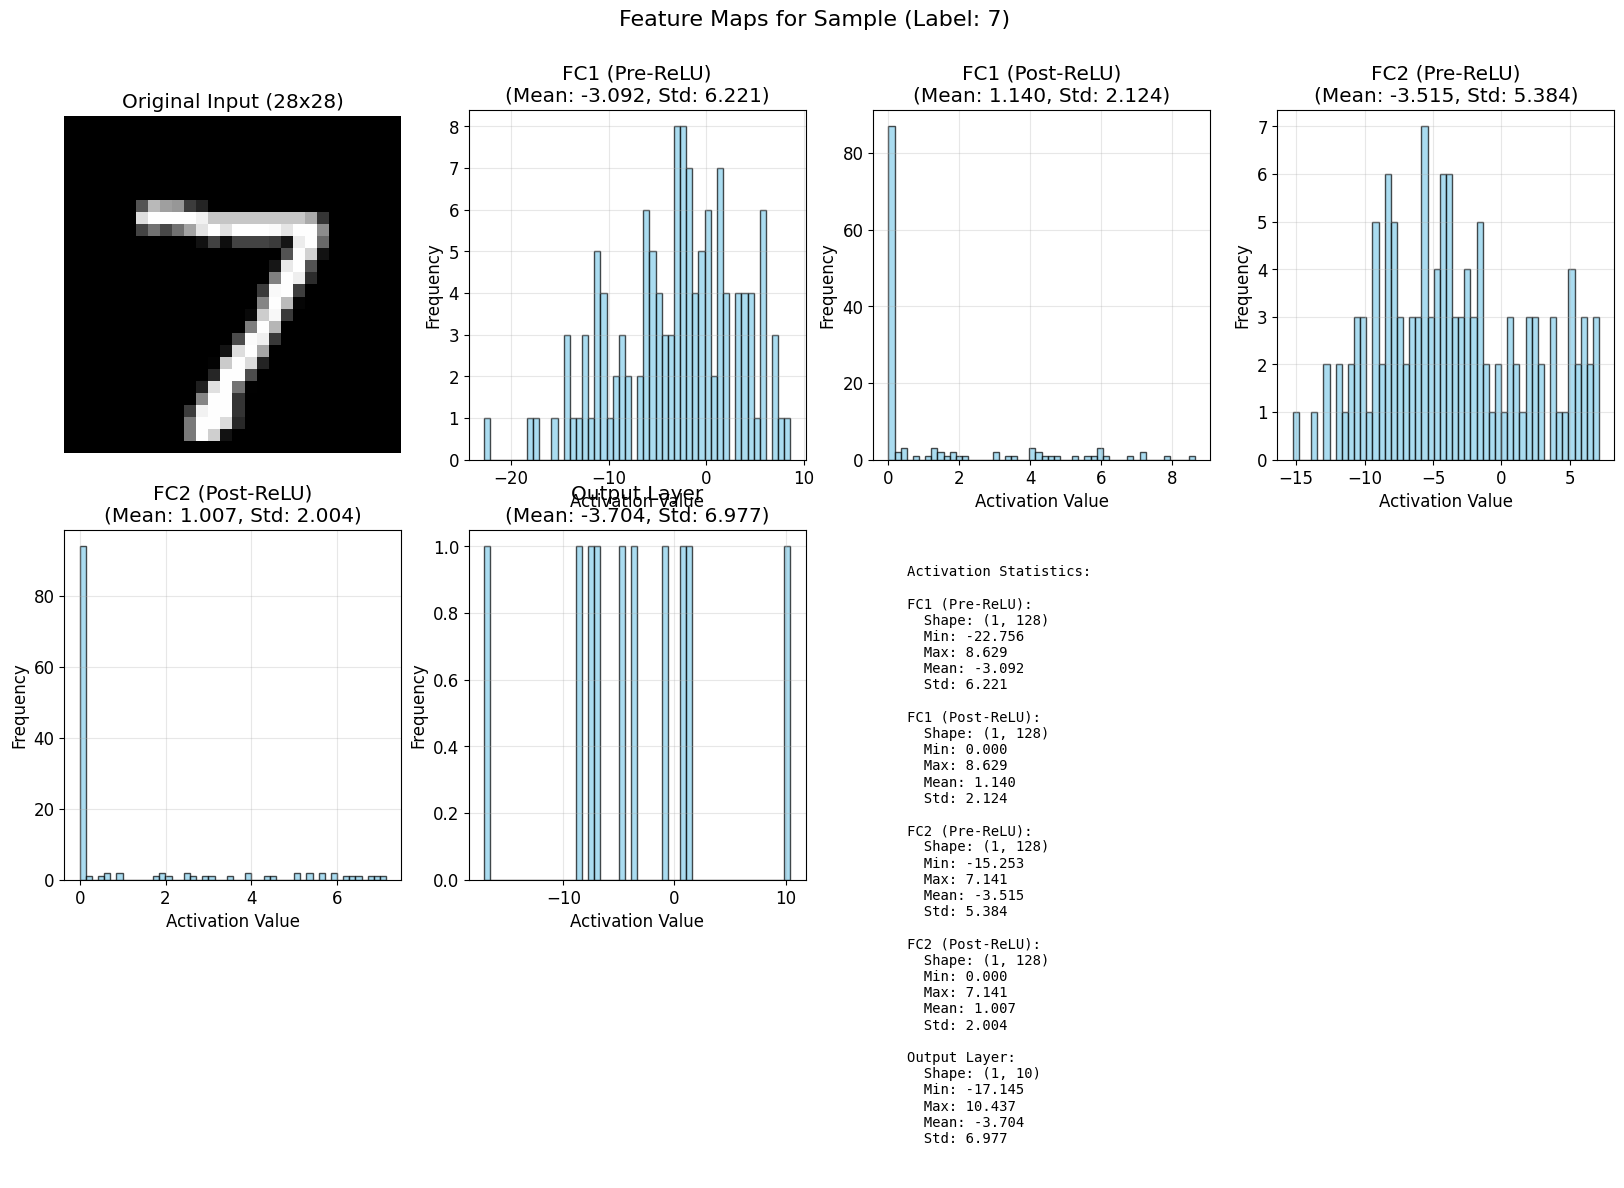

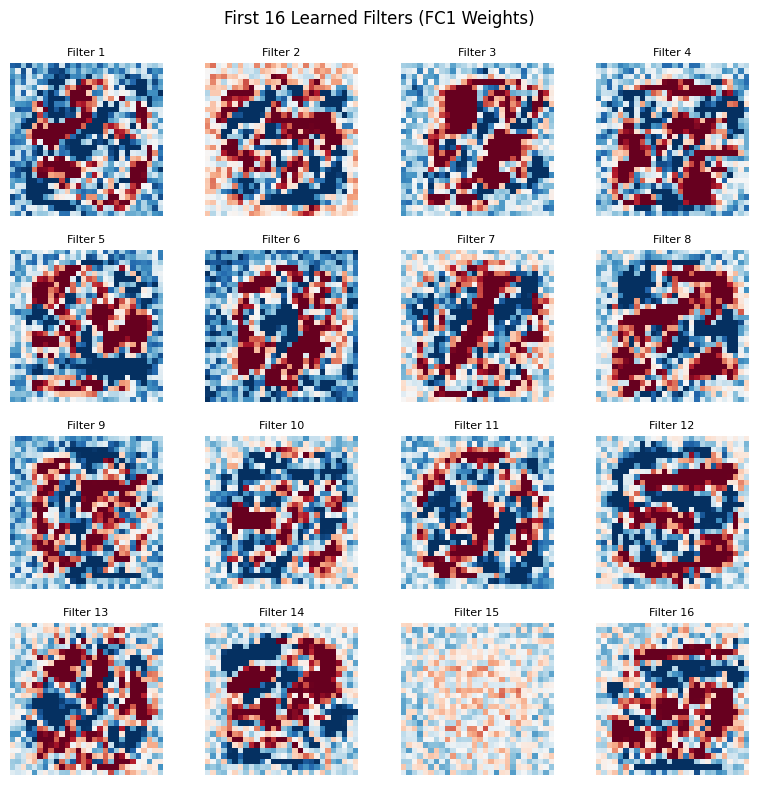

<Figure size 1200x800 with 0 Axes>

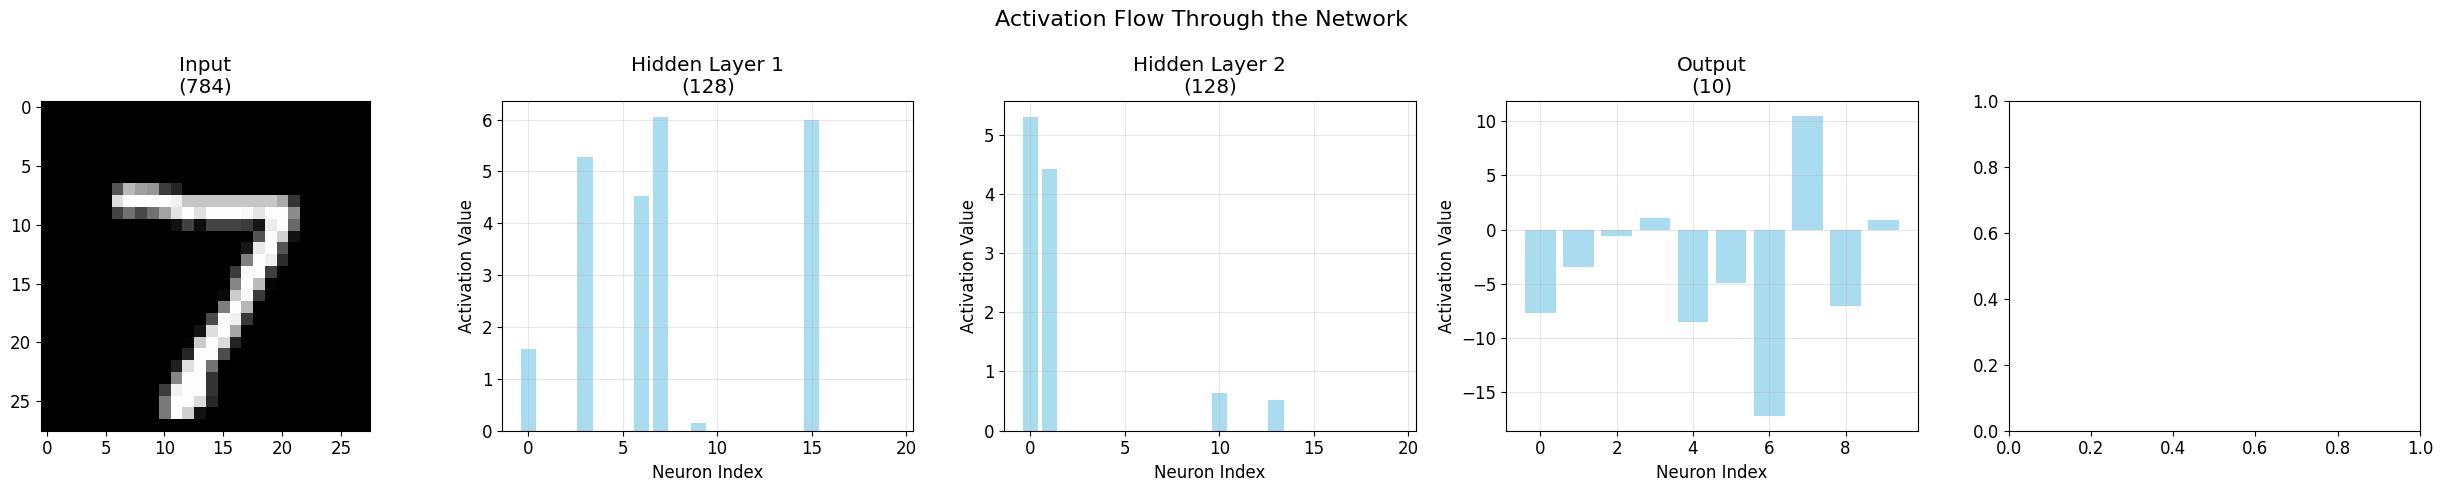

In [13]:
# Visualize feature maps for a sample
sample_idx = 0
sample_image, sample_label = test_dataset[sample_idx]
print(f"Visualizing feature maps for digit {sample_label}")

# Show detailed feature maps
visualize_feature_maps(model, sample_image.unsqueeze(0), sample_label)

# Show activation flow
visualize_activation_flow(model, sample_image.unsqueeze(0))


Visualizing loss landscape around the trained model...
This may take a few minutes...
Computing loss landscape...


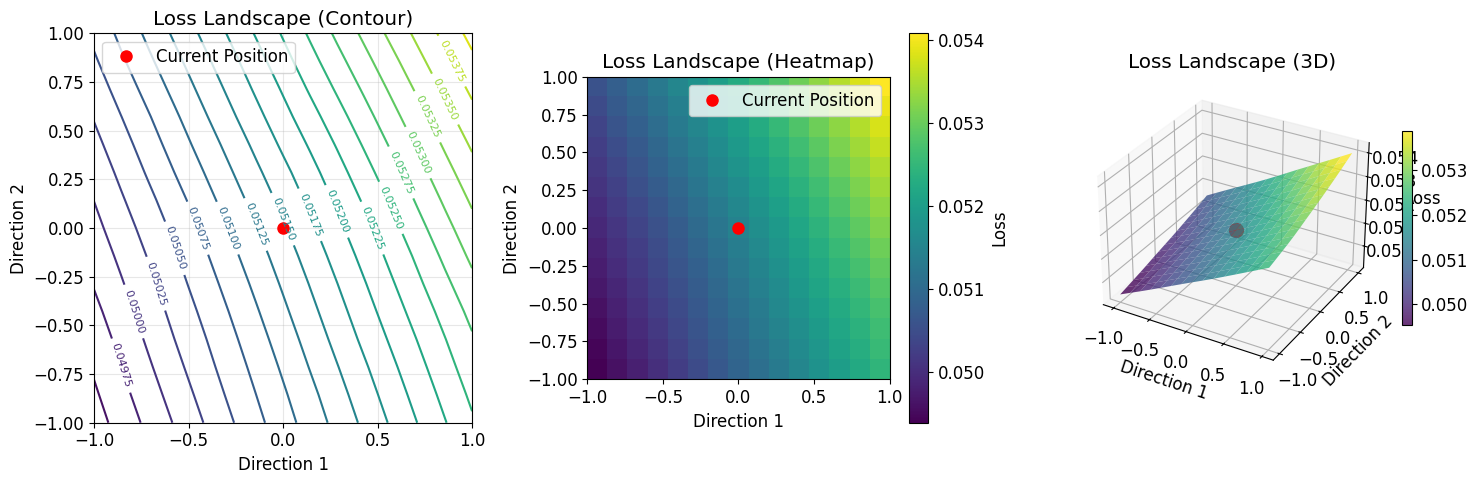

Loss at current position: 0.0515
Minimum loss in landscape: 0.0494
Maximum loss in landscape: 0.0541


In [14]:
# Visualize the loss landscape around the trained model
print("Visualizing loss landscape around the trained model...")
print("This may take a few minutes...")

# Use a smaller resolution for faster computation (you can increase for better quality)
visualize_loss_landscape(model, test_loader, criterion, device, resolution=15)


Creating PCA-based 3D loss landscape visualization...
This explores the loss landscape using Principal Component Analysis...
Generating random parameter perturbations...
Applying PCA to find principal loss directions...


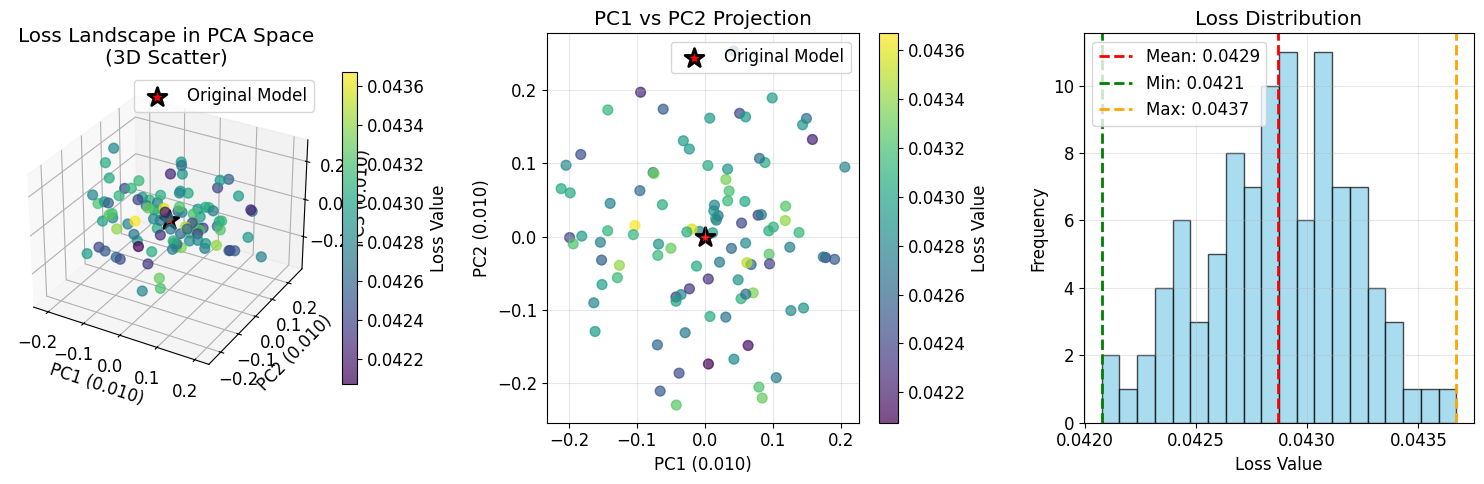


PCA Loss Landscape Analysis:
Explained variance ratios: [0.01049034 0.01036033 0.01033482]
Cumulative explained variance: [0.01049034 0.02085067 0.03118549]
Loss statistics:
  Mean: 0.0429
  Std: 0.0003
  Min: 0.0421
  Max: 0.0437
  Range: 0.0016
\n🔍 PCA Loss Landscape Insights:
This visualization shows how the loss varies in the most important
parameter directions (found using PCA) without using heatmaps.
Each point represents a different model configuration, colored by loss value.


In [15]:
# Visualize loss landscape using PCA to find meaningful directions
print("Creating PCA-based 3D loss landscape visualization...")
print("This explores the loss landscape using Principal Component Analysis...")

# Use the new PCA-based loss landscape visualization
directions_3d, losses_pca, pca_model = visualize_loss_landscape_pca_3d(
    model, test_loader, criterion, device, 
    num_directions=100,  # More directions for better PCA
    perturbation_scale=0.3  # Smaller perturbations for local landscape
)

print("\\n🔍 PCA Loss Landscape Insights:")
print("This visualization shows how the loss varies in the most important")
print("parameter directions (found using PCA) without using heatmaps.")
print("Each point represents a different model configuration, colored by loss value.")


Creating 3D visualizations of the data space...
This will show how the neural network transforms the data...
Applying PCA to raw data...
Applying PCA to learned features...
Applying t-SNE to raw data...


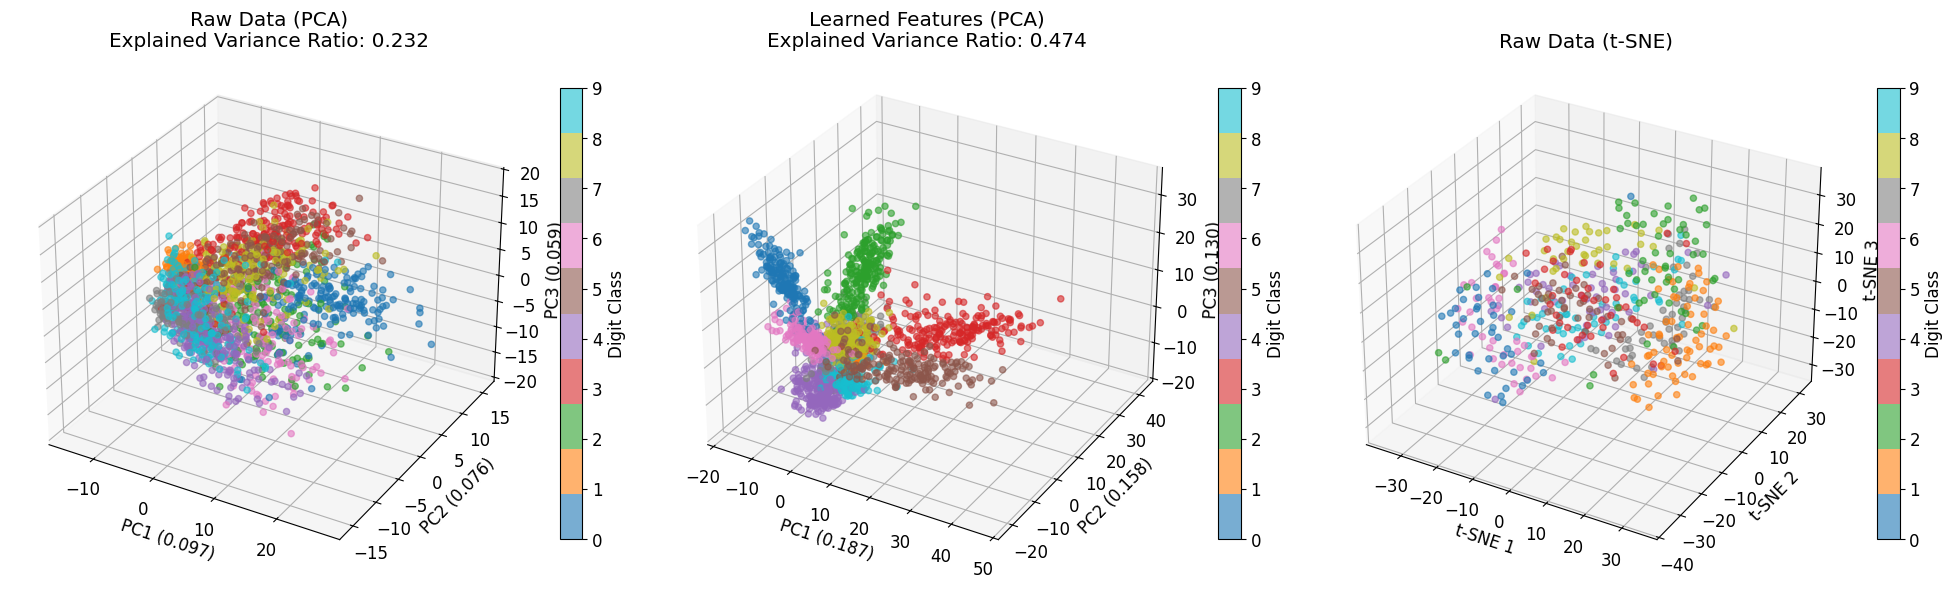


PCA Analysis Results:
Raw Data PCA:
  Explained variance ratio: [0.09713728 0.07558312 0.05910288]
  Cumulative explained variance: [0.09713728 0.1727204  0.23182328]

Learned Features PCA:
  Explained variance ratio: [0.18674901 0.15760304 0.1300721 ]
  Cumulative explained variance: [0.18674901 0.34435207 0.47442418]


In [16]:
# Visualize data in 3D space using PCA and t-SNE
print("Creating 3D visualizations of the data space...")
print("This will show how the neural network transforms the data...")

data_3d, features_3d, labels = visualize_data_space_3d(model, test_loader, device, num_samples=2000)


Evaluating model on test set...
\nBasic Model Performance:
Accuracy: 0.9797 (97.97%)
Precision: 0.9797
Recall: 0.9797
F1-Score: 0.9797
\nCreating comprehensive evaluation dashboard...
\nCreating comprehensive visualization dashboard...


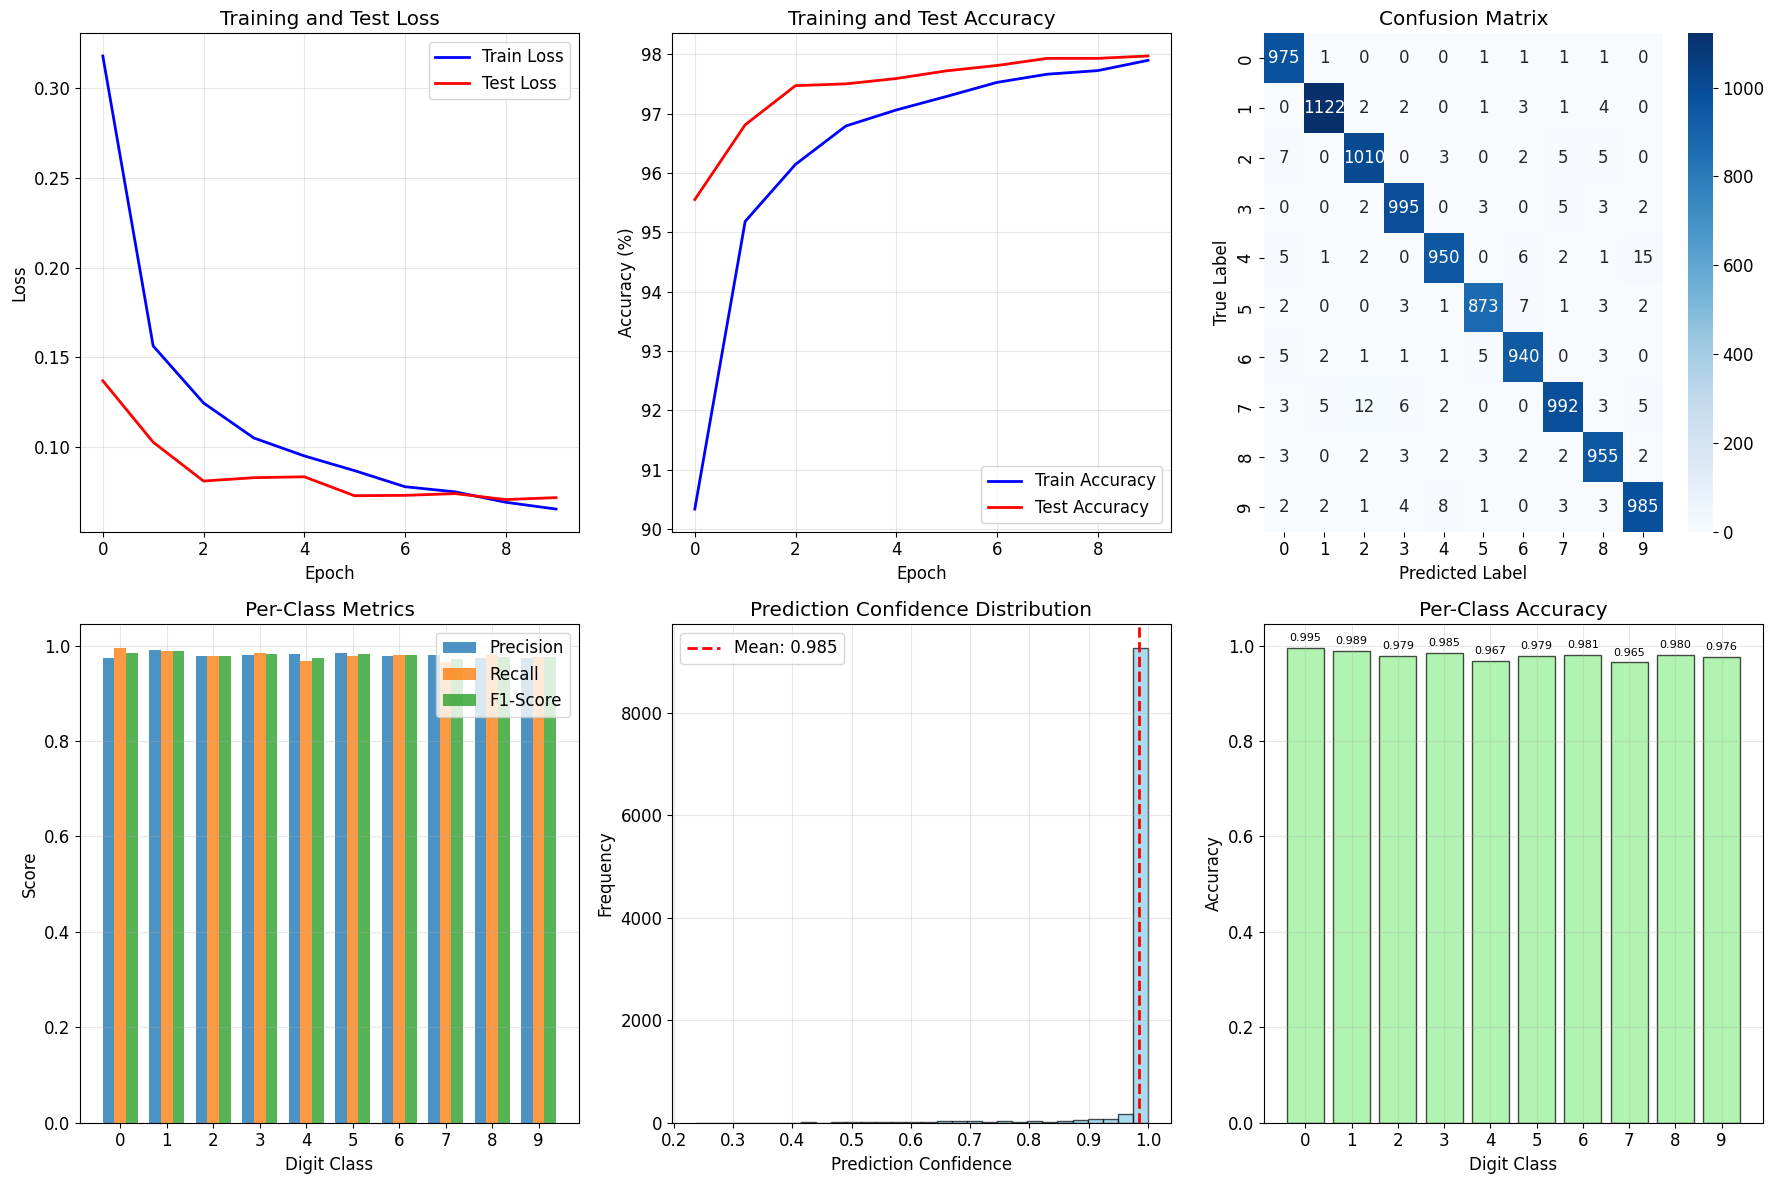

\n📊 COMPREHENSIVE METRICS SUMMARY:
Overall Accuracy: 0.9797 (97.97%)
Precision: 0.9797
Recall: 0.9797
F1-Score: 0.9797
Average Confidence: 0.985
\nDetailed Metrics Summary:
Final Accuracy: 0.9797
Final Precision: 0.9797
Final Recall: 0.9797
Final F1-Score: 0.9797
Per-class accuracies: ['0.995', '0.989', '0.979', '0.985', '0.967', '0.979', '0.981', '0.965', '0.980', '0.976']


In [17]:
# First, evaluate model on test set to collect predictions
print("Evaluating model on test set...")
model.eval()
all_predictions = []
all_targets = []
all_probabilities = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        probabilities = F.softmax(output, dim=1)
        _, predicted = torch.max(output, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)
all_probabilities = np.array(all_probabilities)

# Calculate basic metrics
accuracy = accuracy_score(all_targets, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted')

print(f"\\nBasic Model Performance:")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Now use the comprehensive metrics visualization
print("\\nCreating comprehensive evaluation dashboard...")

# This will create a detailed analysis with all requested metrics
print("\\nCreating comprehensive visualization dashboard...")

# Use the new, fixed comprehensive metrics function
metrics_summary = create_comprehensive_plots(
    train_losses, train_accuracies, test_losses, test_accuracies,
    all_targets, all_predictions, all_probabilities
)

print("\\nDetailed Metrics Summary:")
print(f"Final Accuracy: {metrics_summary['accuracy']:.4f}")
print(f"Final Precision: {metrics_summary['precision']:.4f}")
print(f"Final Recall: {metrics_summary['recall']:.4f}")
print(f"Final F1-Score: {metrics_summary['f1']:.4f}")
print(f"Per-class accuracies: {[f'{acc:.3f}' for acc in metrics_summary['class_accuracies']]}")


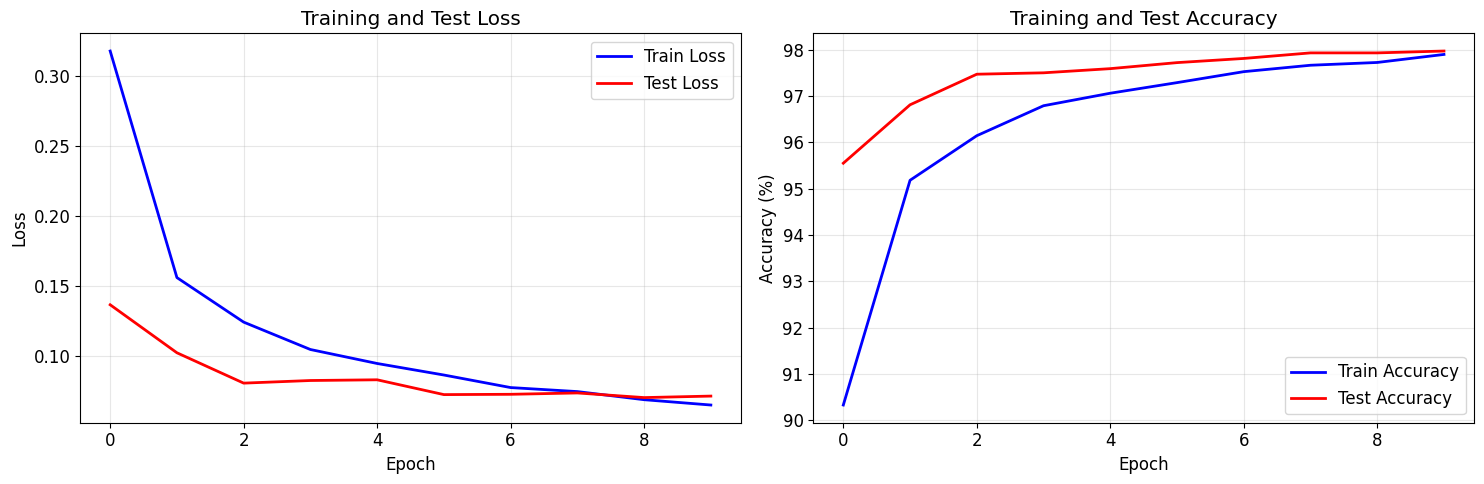

Final Training Loss: 0.0653
Final Training Accuracy: 97.90%
Final Test Loss: 0.0717
Final Test Accuracy: 97.97%


In [18]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
ax1.plot(test_losses, label='Test Loss', color='red', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accuracies, label='Train Accuracy', color='blue', linewidth=2)
ax2.plot(test_accuracies, label='Test Accuracy', color='red', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final results
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Test Loss: {test_losses[-1]:.4f}")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")


In [19]:
# Additional educational insights
print("🧠 DEEP LEARNING INSIGHTS")
print("=" * 50)

print("\\n📊 Dataset Characteristics:")
print(f"• Total parameters in model: {sum(p.numel() for p in model.parameters()):,}")
print(f"• Training samples: {len(train_dataset):,}")
print(f"• Parameters-to-data ratio: 1:{len(train_dataset) // sum(p.numel() for p in model.parameters())}")

print("\\n🎯 Model Architecture Benefits:")
print("• Fully connected layers: Learn any input-output mapping")
print("• ReLU activation: Enables non-linear learning")
print("• Dropout: Prevents overfitting by adding randomness")
print("• Cross-entropy loss: Encourages confident, correct predictions")

print("\\n📈 Training Process:")
print(f"• Optimizer: Adam (adaptive learning rate)")
print(f"• Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"• Batch size: {batch_size} (good balance of efficiency and stability)")
print(f"• Total training steps: {len(train_loader) * num_epochs:,}")

print("\\n🔍 Performance Analysis:")
best_epoch = np.argmax(test_accuracies) + 1
print(f"• Best test accuracy: {max(test_accuracies):.2f}% (Epoch {best_epoch})")
print(f"• Final overfitting gap: {train_accuracies[-1] - test_accuracies[-1]:.2f}%")
print(f"• Model converged: {'Yes' if abs(train_losses[-1] - train_losses[-2]) < 0.01 else 'No'}")

print("\\n💡 Key Takeaways:")
print("• Simple networks can achieve high accuracy on MNIST")
print("• Feature visualization helps understand what networks learn")
print("• Loss landscapes reveal optimization characteristics")
print("• 3D visualization shows how networks transform data")
print("• Comprehensive metrics provide full performance picture")


🧠 DEEP LEARNING INSIGHTS
\n📊 Dataset Characteristics:
• Total parameters in model: 118,282
• Training samples: 60,000
• Parameters-to-data ratio: 1:0
\n🎯 Model Architecture Benefits:
• Fully connected layers: Learn any input-output mapping
• ReLU activation: Enables non-linear learning
• Dropout: Prevents overfitting by adding randomness
• Cross-entropy loss: Encourages confident, correct predictions
\n📈 Training Process:
• Optimizer: Adam (adaptive learning rate)
• Learning rate: 0.001
• Batch size: 64 (good balance of efficiency and stability)
• Total training steps: 9,380
\n🔍 Performance Analysis:
• Best test accuracy: 97.97% (Epoch 10)
• Final overfitting gap: -0.07%
• Model converged: Yes
\n💡 Key Takeaways:
• Simple networks can achieve high accuracy on MNIST
• Feature visualization helps understand what networks learn
• Loss landscapes reveal optimization characteristics
• 3D visualization shows how networks transform data
• Comprehensive metrics provide full performance picture


In [20]:
# Evaluate model on test set
model.eval()
all_predictions = []
all_targets = []
all_probabilities = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        probabilities = F.softmax(output, dim=1)
        _, predicted = torch.max(output, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)
all_probabilities = np.array(all_probabilities)

# Calculate metrics
accuracy = accuracy_score(all_targets, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted')

print(f"\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



Model Performance Metrics:
Accuracy: 0.9797 (97.97%)
Precision: 0.9797
Recall: 0.9797
F1-Score: 0.9797


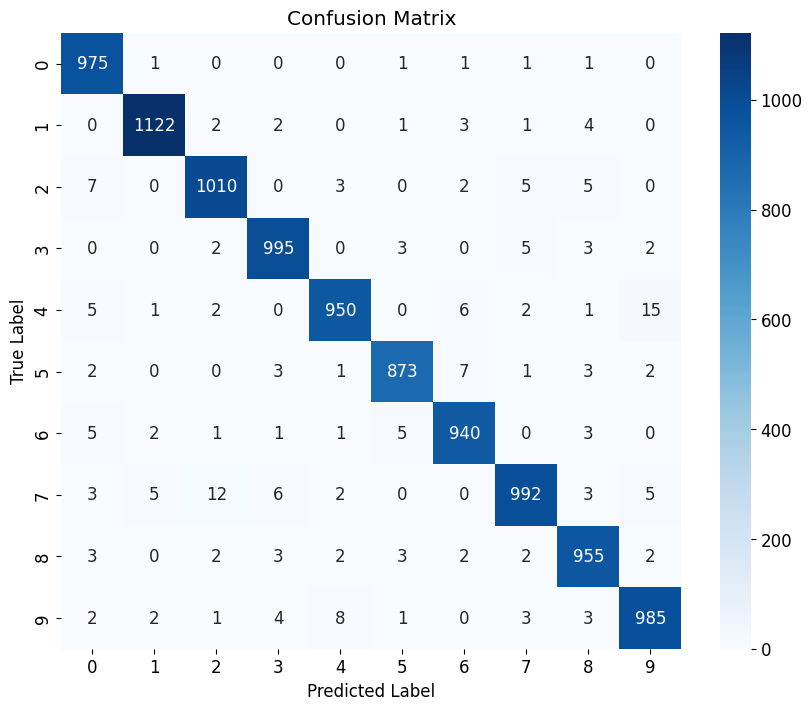


Per-class metrics:
   Class  Precision  Recall  F1-Score
0      0     0.9731  0.9949    0.9839
1      1     0.9903  0.9885    0.9894
2      2     0.9787  0.9787    0.9787
3      3     0.9813  0.9851    0.9832
4      4     0.9824  0.9674    0.9749
5      5     0.9842  0.9787    0.9815
6      6     0.9781  0.9812    0.9797
7      7     0.9802  0.9650    0.9725
8      8     0.9735  0.9805    0.9770
9      9     0.9743  0.9762    0.9752


In [21]:
# Confusion Matrix
cm = confusion_matrix(all_targets, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Per-class metrics
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    all_targets, all_predictions, average=None
)

class_metrics = pd.DataFrame({
    'Class': range(10),
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
})

print("\nPer-class metrics:")
print(class_metrics.round(4))


Finding wrong predictions...
Found 20 wrong predictions to analyze


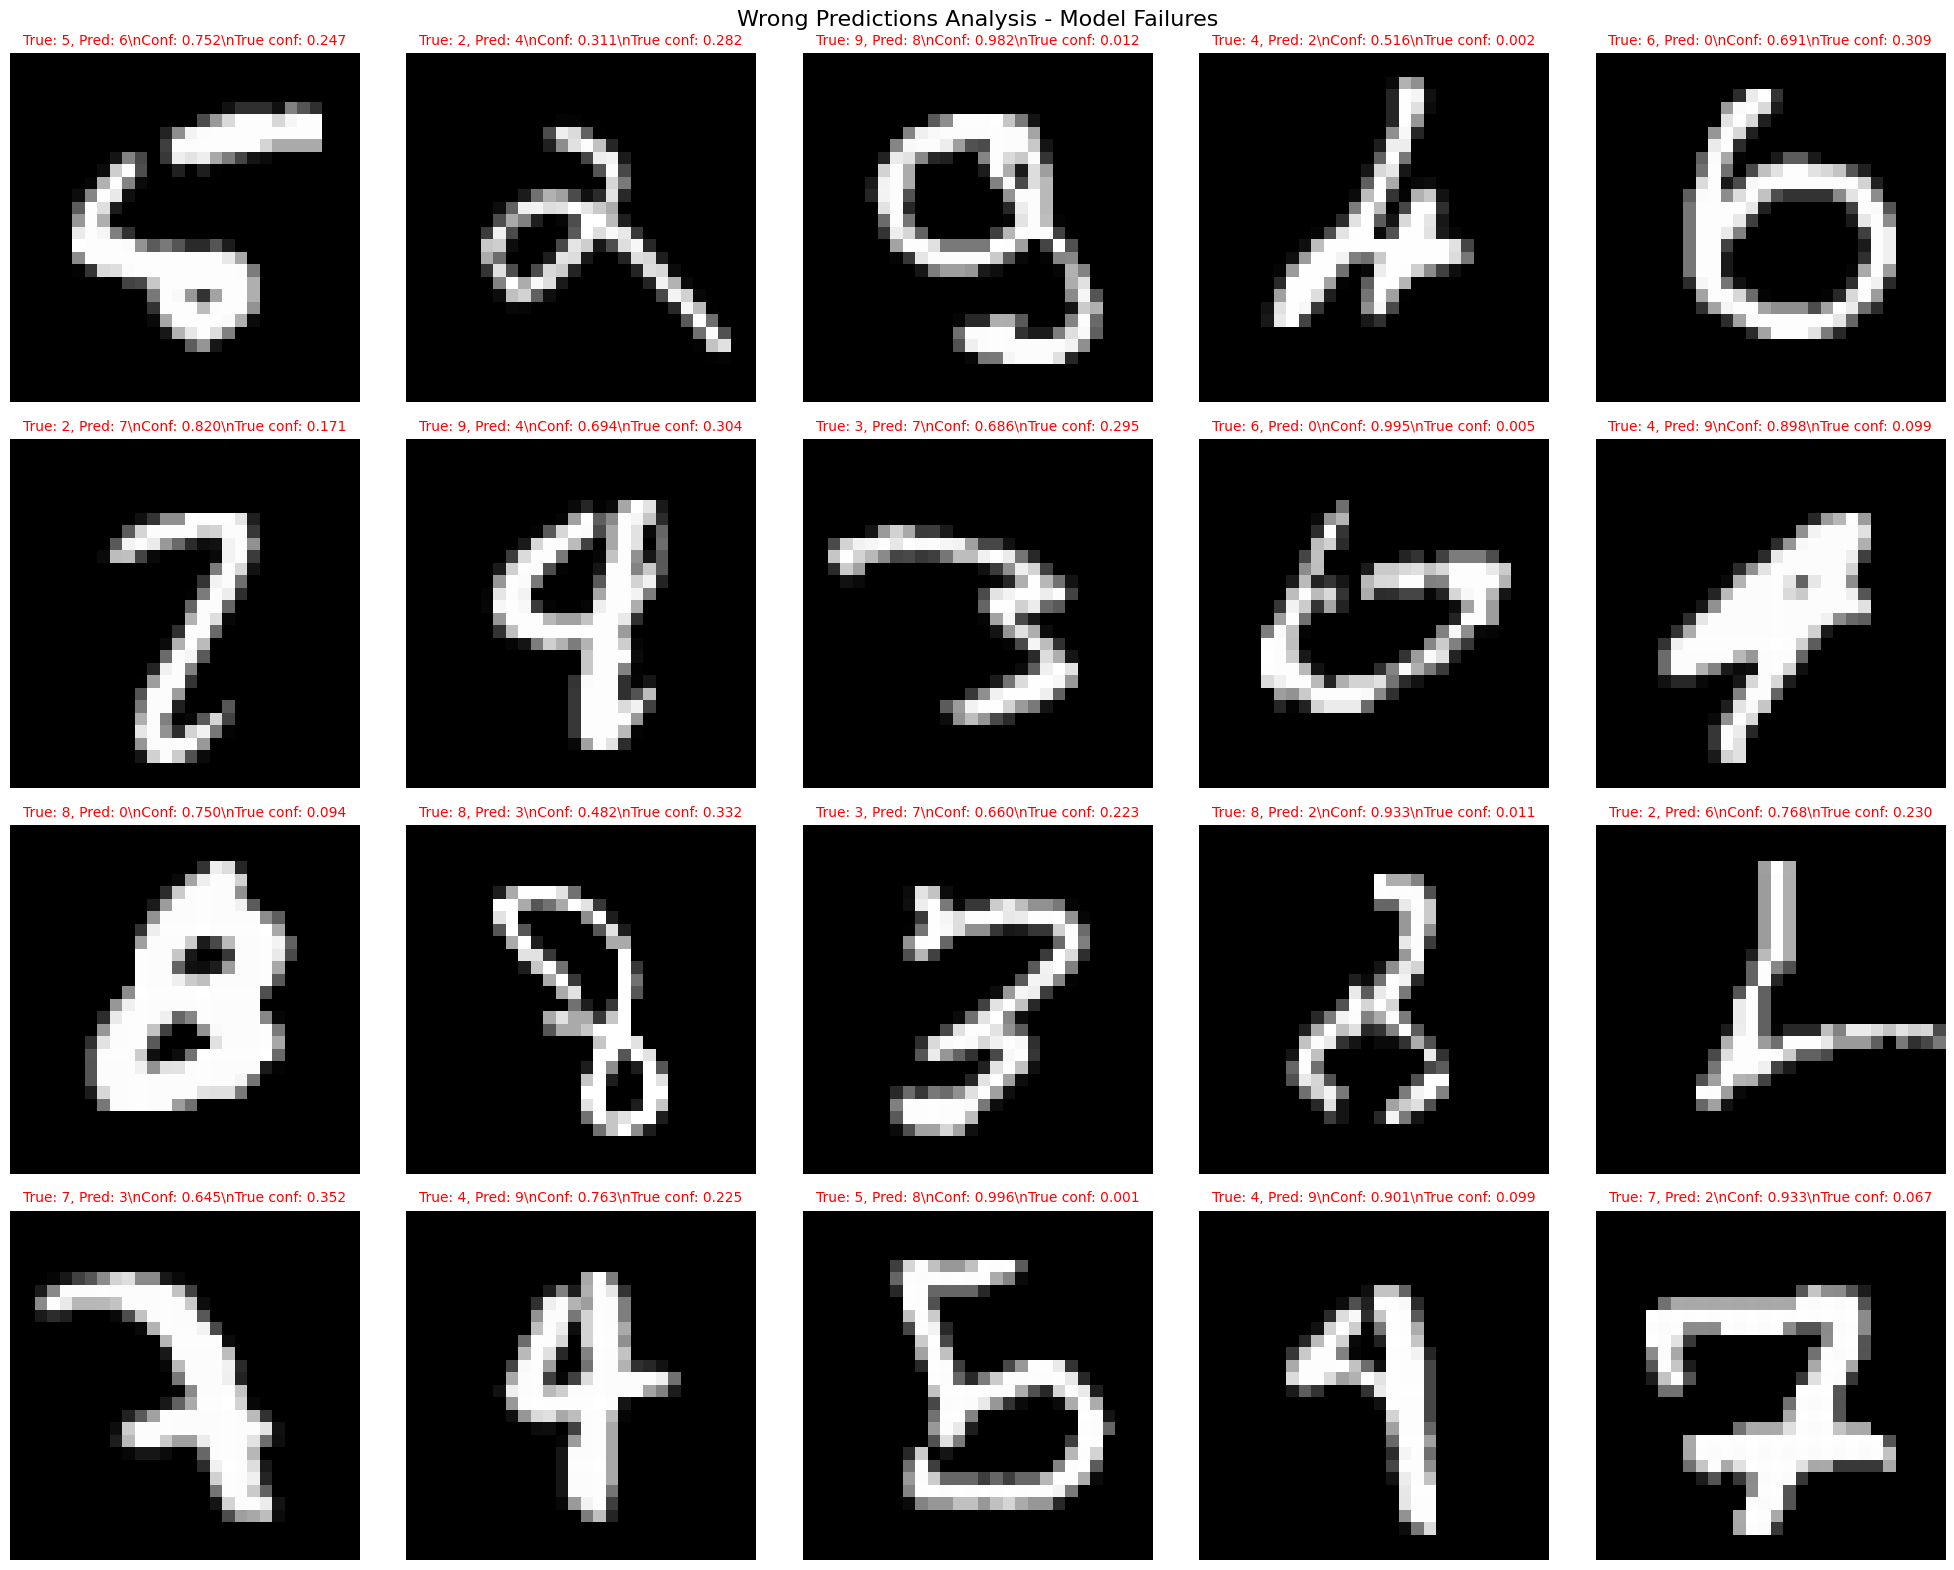

\n🔍 WRONG PREDICTIONS ANALYSIS:
\n📊 Statistics:
• Average confidence in wrong predictions: 0.759
• Min confidence: 0.311
• Max confidence: 0.996
\n🎯 Most common misclassifications:
• 4 → 9: 3 times
• 6 → 0: 2 times
• 3 → 7: 2 times
• 5 → 6: 1 times
• 2 → 4: 1 times
\n❌ Classes most often misclassified:
• Class 4: 4 wrong predictions
• Class 2: 3 wrong predictions
• Class 8: 3 wrong predictions
• Class 5: 2 wrong predictions
• Class 9: 2 wrong predictions
\n💡 Insights:
• Low confidence wrong predictions suggest uncertainty
• High confidence wrong predictions suggest systematic errors
• Common misclassifications reveal similar-looking digits
• Analyzing these patterns can guide model improvements


In [22]:
# Analyze and visualize wrong predictions to understand model failures
def analyze_wrong_predictions(model, test_loader, device, num_examples=16):
    """Find and visualize images that were incorrectly predicted"""
    model.eval()
    wrong_predictions = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            probabilities = F.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)
            
            # Find wrong predictions
            wrong_mask = predicted != target
            wrong_indices = torch.where(wrong_mask)[0]
            
            for idx in wrong_indices:
                if len(wrong_predictions) >= num_examples:
                    break
                    
                wrong_predictions.append({
                    'image': data[idx].cpu(),
                    'true_label': target[idx].item(),
                    'predicted_label': predicted[idx].item(),
                    'confidence': probabilities[idx][predicted[idx]].item(),
                    'true_confidence': probabilities[idx][target[idx]].item()
                })
            
            if len(wrong_predictions) >= num_examples:
                break
    
    return wrong_predictions

# Get wrong predictions
print("Finding wrong predictions...")
wrong_preds = analyze_wrong_predictions(model, test_loader, device, num_examples=20)

print(f"Found {len(wrong_preds)} wrong predictions to analyze")

# Visualize wrong predictions
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.ravel()

for i, wrong_pred in enumerate(wrong_preds):
    if i >= 20:
        break
        
    img = wrong_pred['image'].squeeze()
    true_label = wrong_pred['true_label']
    pred_label = wrong_pred['predicted_label']
    confidence = wrong_pred['confidence']
    true_confidence = wrong_pred['true_confidence']
    
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(
        f'True: {true_label}, Pred: {pred_label}\\n'
        f'Conf: {confidence:.3f}\\n'
        f'True conf: {true_confidence:.3f}',
        color='red', fontsize=10
    )
    axes[i].axis('off')

plt.suptitle('Wrong Predictions Analysis - Model Failures', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Analyze patterns in wrong predictions
print("\\n🔍 WRONG PREDICTIONS ANALYSIS:")
print("=" * 50)

# Count wrong predictions by true class
true_labels = [wp['true_label'] for wp in wrong_preds]
pred_labels = [wp['predicted_label'] for wp in wrong_preds]
confidences = [wp['confidence'] for wp in wrong_preds]

print(f"\\n📊 Statistics:")
print(f"• Average confidence in wrong predictions: {np.mean(confidences):.3f}")
print(f"• Min confidence: {np.min(confidences):.3f}")
print(f"• Max confidence: {np.max(confidences):.3f}")

# Most common misclassifications
from collections import Counter
misclassifications = [(true, pred) for true, pred in zip(true_labels, pred_labels)]
most_common = Counter(misclassifications).most_common(5)

print(f"\\n🎯 Most common misclassifications:")
for (true_class, pred_class), count in most_common:
    print(f"• {true_class} → {pred_class}: {count} times")

# Classes most often confused
true_counter = Counter(true_labels)
print(f"\\n❌ Classes most often misclassified:")
for class_id, count in true_counter.most_common(5):
    print(f"• Class {class_id}: {count} wrong predictions")

print(f"\\n💡 Insights:")
print("• Low confidence wrong predictions suggest uncertainty")
print("• High confidence wrong predictions suggest systematic errors")
print("• Common misclassifications reveal similar-looking digits")
print("• Analyzing these patterns can guide model improvements")


\n🎯 DETAILED CONFUSION ANALYSIS:
\n1. 4 confused as 9: 3 cases
   Average wrong confidence: 0.854
   Average true confidence: 0.141
   Confidence gap: 0.713
\n2. 6 confused as 0: 2 cases
   Average wrong confidence: 0.843
   Average true confidence: 0.157
   Confidence gap: 0.686
\n3. 3 confused as 7: 2 cases
   Average wrong confidence: 0.673
   Average true confidence: 0.259
   Confidence gap: 0.414
\n4. 5 confused as 6: 1 cases
   Average wrong confidence: 0.752
   Average true confidence: 0.247
   Confidence gap: 0.505
\n5. 2 confused as 4: 1 cases
   Average wrong confidence: 0.311
   Average true confidence: 0.282
   Confidence gap: 0.029
\n6. 9 confused as 8: 1 cases
   Average wrong confidence: 0.982
   Average true confidence: 0.012
   Confidence gap: 0.970


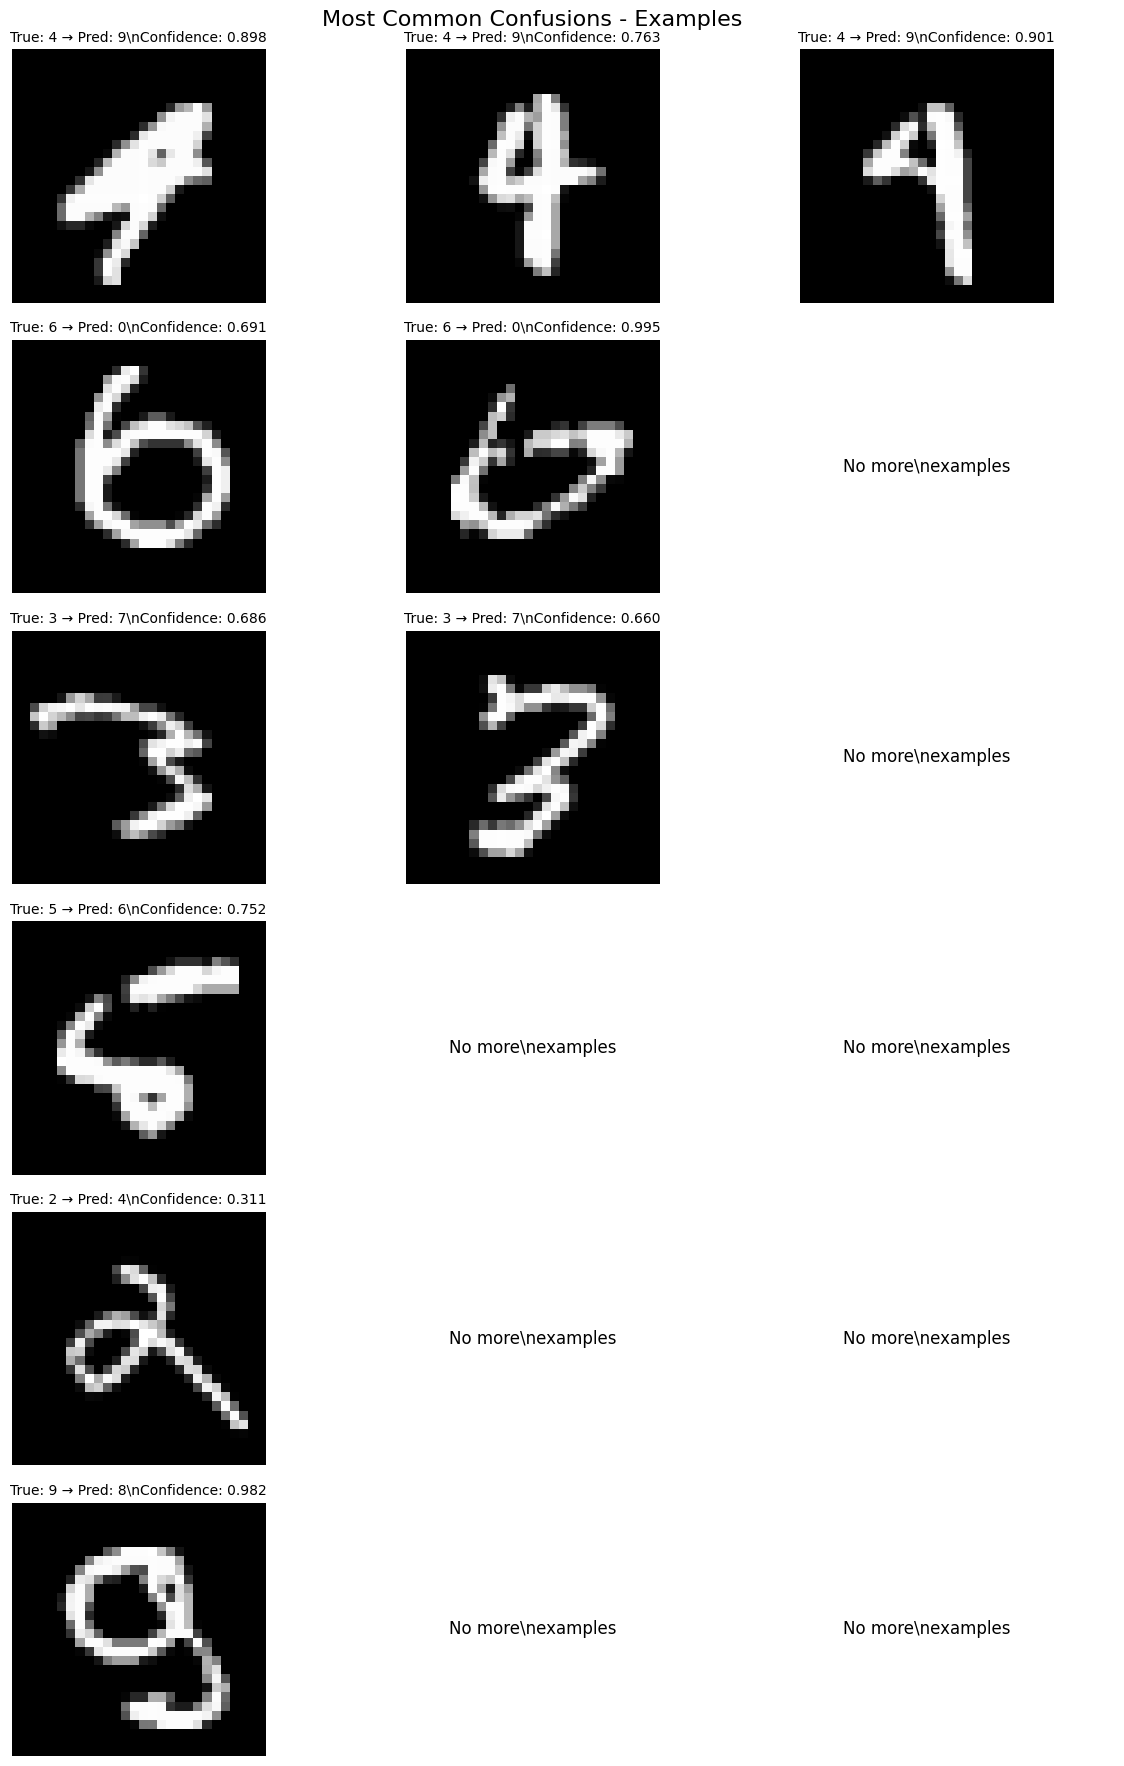

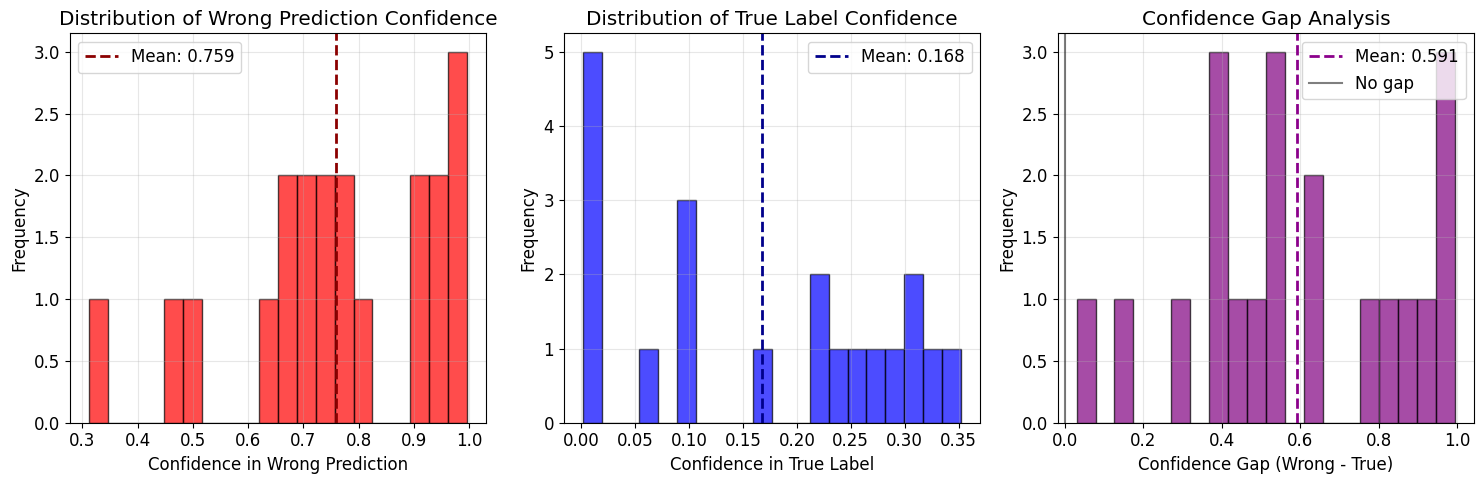

\n📈 CONFIDENCE ANALYSIS:
• Average confidence in wrong predictions: 0.759
• Average confidence in true labels: 0.168
• Average confidence gap: 0.591
• Models with positive gaps are overconfident in wrong predictions
• Models with negative gaps are underconfident overall


In [23]:
# Create detailed confusion analysis with examples
def create_confusion_analysis(wrong_preds):
    """Create detailed analysis of confusion patterns"""
    
    # Group wrong predictions by (true_label, predicted_label)
    confusion_groups = {}
    for wp in wrong_preds:
        key = (wp['true_label'], wp['predicted_label'])
        if key not in confusion_groups:
            confusion_groups[key] = []
        confusion_groups[key].append(wp)
    
    # Sort by frequency
    sorted_confusions = sorted(confusion_groups.items(), 
                              key=lambda x: len(x[1]), reverse=True)
    
    print("\\n🎯 DETAILED CONFUSION ANALYSIS:")
    print("=" * 60)
    
    # Show top confusions with examples
    fig, axes = plt.subplots(len(sorted_confusions[:6]), 3, figsize=(12, 18))
    if len(sorted_confusions) == 1:
        axes = axes.reshape(1, -1)
    
    for i, ((true_label, pred_label), examples) in enumerate(sorted_confusions[:6]):
        print(f"\\n{i+1}. {true_label} confused as {pred_label}: {len(examples)} cases")
        
        # Show up to 3 examples
        for j, example in enumerate(examples[:3]):
            if i < len(axes) and j < len(axes[i]):
                axes[i, j].imshow(example['image'].squeeze(), cmap='gray')
                axes[i, j].set_title(
                    f'True: {true_label} → Pred: {pred_label}\\n'
                    f'Confidence: {example["confidence"]:.3f}',
                    fontsize=10
                )
                axes[i, j].axis('off')
        
        # Fill empty subplots
        for j in range(len(examples), 3):
            if i < len(axes) and j < len(axes[i]):
                axes[i, j].axis('off')
                axes[i, j].text(0.5, 0.5, 'No more\\nexamples', 
                               ha='center', va='center', transform=axes[i, j].transAxes)
        
        # Calculate statistics for this confusion
        confs = [ex['confidence'] for ex in examples]
        true_confs = [ex['true_confidence'] for ex in examples]
        print(f"   Average wrong confidence: {np.mean(confs):.3f}")
        print(f"   Average true confidence: {np.mean(true_confs):.3f}")
        print(f"   Confidence gap: {np.mean(confs) - np.mean(true_confs):.3f}")
    
    plt.suptitle('Most Common Confusions - Examples', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return confusion_groups

# Create detailed confusion analysis
confusion_groups = create_confusion_analysis(wrong_preds)

# Additional visualization: Confidence distribution for wrong predictions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
confidences = [wp['confidence'] for wp in wrong_preds]
plt.hist(confidences, bins=20, alpha=0.7, color='red', edgecolor='black')
plt.axvline(np.mean(confidences), color='darkred', linestyle='--', linewidth=2,
           label=f'Mean: {np.mean(confidences):.3f}')
plt.xlabel('Confidence in Wrong Prediction')
plt.ylabel('Frequency')
plt.title('Distribution of Wrong Prediction Confidence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
true_confidences = [wp['true_confidence'] for wp in wrong_preds]
plt.hist(true_confidences, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(np.mean(true_confidences), color='darkblue', linestyle='--', linewidth=2,
           label=f'Mean: {np.mean(true_confidences):.3f}')
plt.xlabel('Confidence in True Label')
plt.ylabel('Frequency')
plt.title('Distribution of True Label Confidence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
confidence_gaps = [wp['confidence'] - wp['true_confidence'] for wp in wrong_preds]
plt.hist(confidence_gaps, bins=20, alpha=0.7, color='purple', edgecolor='black')
plt.axvline(np.mean(confidence_gaps), color='darkmagenta', linestyle='--', linewidth=2,
           label=f'Mean: {np.mean(confidence_gaps):.3f}')
plt.axvline(0, color='black', linestyle='-', alpha=0.5, label='No gap')
plt.xlabel('Confidence Gap (Wrong - True)')
plt.ylabel('Frequency')
plt.title('Confidence Gap Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\\n📈 CONFIDENCE ANALYSIS:")
print(f"• Average confidence in wrong predictions: {np.mean(confidences):.3f}")
print(f"• Average confidence in true labels: {np.mean(true_confidences):.3f}")
print(f"• Average confidence gap: {np.mean(confidence_gaps):.3f}")
print(f"• Models with positive gaps are overconfident in wrong predictions")
print(f"• Models with negative gaps are underconfident overall")


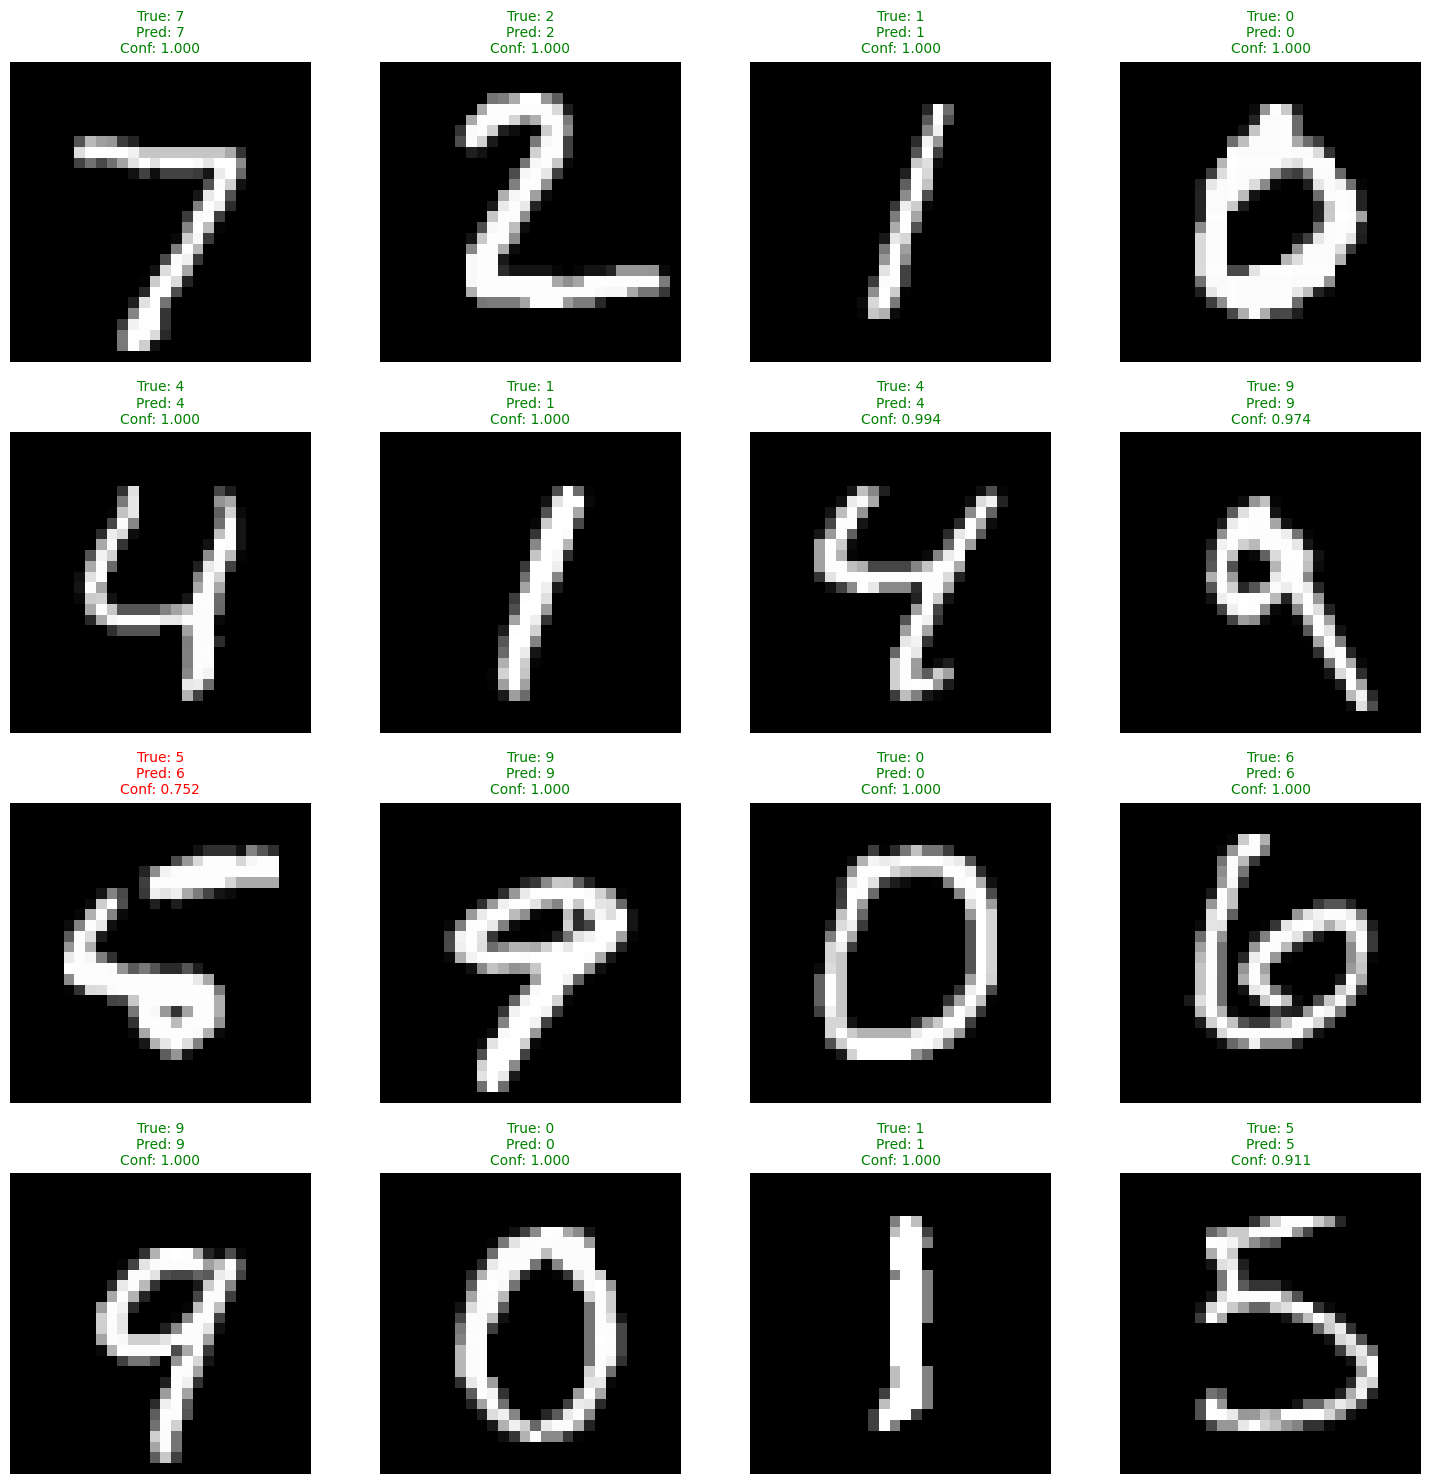

Batch accuracy: 0.9375 (93.75%)


In [24]:
# Get a batch of test data
data_iter = iter(test_loader)
images, labels = next(data_iter)
images = images[:16]  # Take first 16 images
labels = labels[:16]

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(images.to(device))
    probabilities = F.softmax(outputs, dim=1)
    _, predicted = torch.max(outputs, 1)

# Visualize predictions
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.ravel()

for i in range(16):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    true_label = labels[i].item()
    pred_label = predicted[i].item()
    confidence = probabilities[i][pred_label].item()
    
    color = 'green' if true_label == pred_label else 'red'
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}', 
                      color=color, fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Calculate accuracy for this batch
batch_accuracy = (predicted == labels.to(device)).float().mean().item()
print(f"Batch accuracy: {batch_accuracy:.4f} ({batch_accuracy*100:.2f}%)")
